In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arc import *
from time import time
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from typing import List, Dict

from basics import *
from utility import *
from floquet_hamiltonian import *

pi=np.pi
tau=2*pi

# Plot old measured polarizabilities

In [2]:
exp_pol = pd.read_csv("Pin1_4780MHz_Polarizabilities.csv")

results_dir = r"Shirley-Floquet_results\PolarizabilityPlots\RawData"
plots_dir =  r"Shirley-Floquet_results\PolarizabilityPlots"

In [3]:
exp_pol

,RF power (dBm),RF Frequency (MHz),Effective Polarizability 0 (MHz/V^2),Error 0 (MHz/V^2),Effective Polarizability 1 (MHz/V^2),Error 1 (MHz/V^2),Effective Polarizability 2 (MHz/V^2),Error 2 (MHz/V^2),Effective Polarizability 3 (MHz/V^2),Error 3 (MHz/V^2)
0,-100.0,4780,-3.51,0.04,NaN,NaN,NaN,NaN,NaN,NaN
1,-17.0,4780,-2.40,0.05,-2.78,0.060,NaN,NaN,-2.33,0.03
2,-15.0,4780,-2.46,0.09,-2.76,0.140,NaN,NaN,-2.26,0.19
3,-14.0,4780,-2.36,0.04,-2.44,0.160,NaN,NaN,-2.17,0.13
4,-11.0,4780,-2.02,0.08,-2.07,0.150,-2.22,0.16,-2.32,0.15
5,-9.0,4780,-1.97,0.10,-1.85,0.470,-1.95,0.03,-2.26,0.47
6,-6.5,4780,-1.53,0.17,-1.00,0.272,-1.62,0.52,-1.96,0.35


<IPython.core.display.Javascript object>


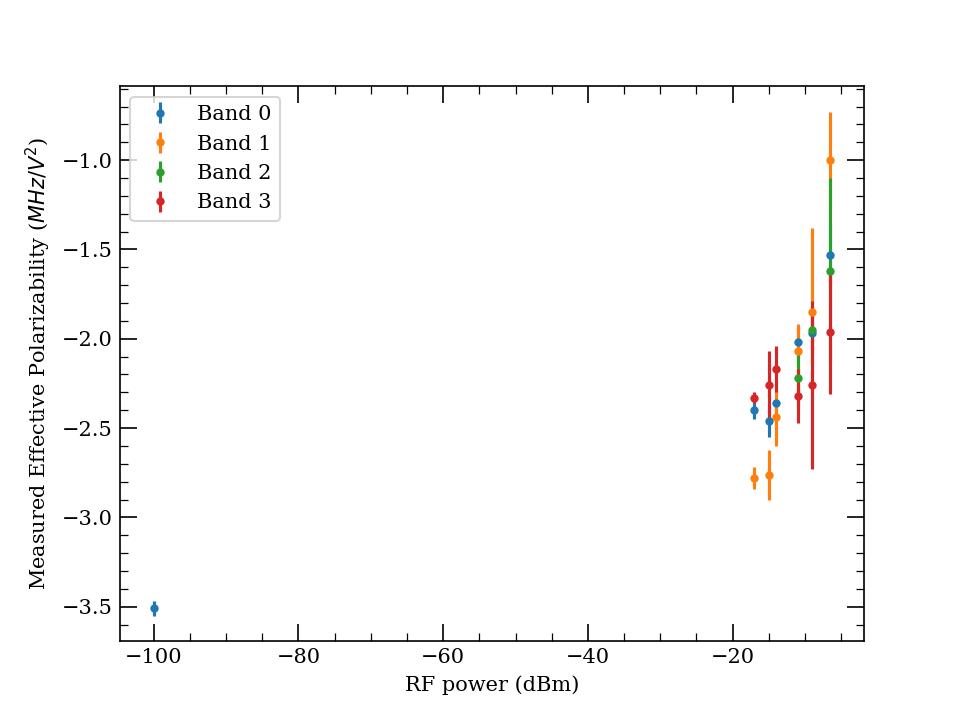

In [4]:
x_dat = exp_pol["RF power (dBm)"]
y_str = "Effective Polarizability {} (MHz/V^2)"
er_str = "Error {} (MHz/V^2)"
fig, ax = plt.subplots(1,1)
for band in range(4):
    y_dat = exp_pol[y_str.format(band)]
    y_err = exp_pol[er_str.format(band)]
    ax.errorbar(x_dat,y_dat,yerr=y_err,fmt=".",label = f"Band {band}")
ax.legend()
ax.set_xlabel("RF power (dBm)")
ax.set_ylabel("Measured Effective Polarizability ($MHz/V^2$)")
fig.show()

<IPython.core.display.Javascript object>


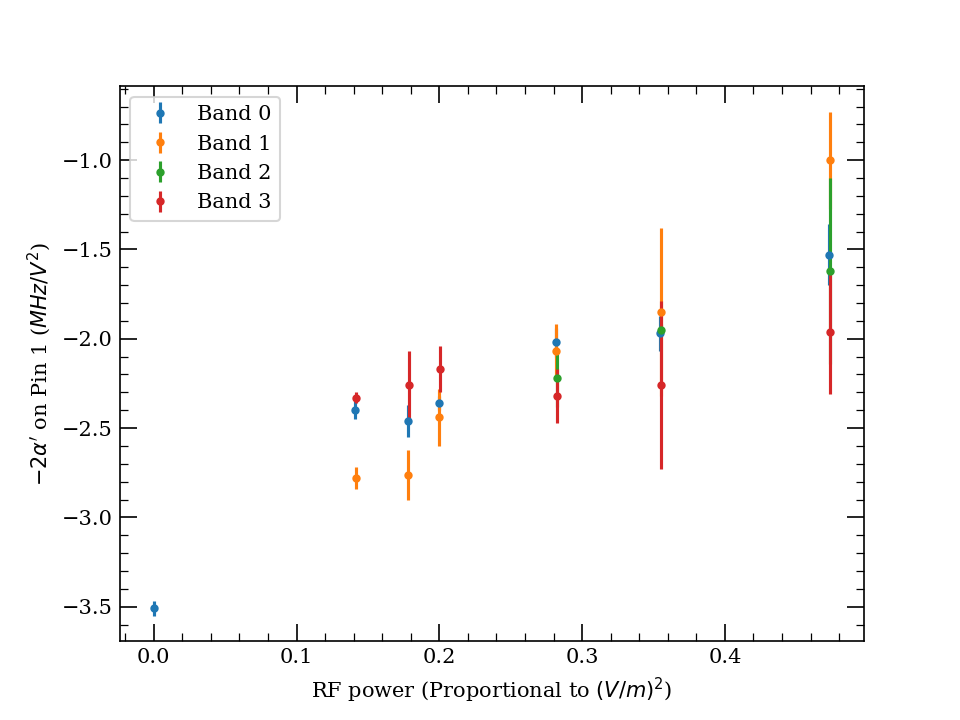

In [15]:
x_dat_dB = exp_pol["RF power (dBm)"]
x_dat_scale = np.sqrt(10**(x_dat_dB/10))
y_str = "Effective Polarizability {} (MHz/V^2)"
er_str = "Error {} (MHz/V^2)"
fig, ax = plt.subplots(1,1)
for band in range(4):
    y_dat = exp_pol[y_str.format(band)]
    y_err = exp_pol[er_str.format(band)]
    ax.errorbar(x_dat_scale+band*2e-4,y_dat,yerr=y_err,fmt=".",label = f"Band {band}")
ax.legend()
ax.set_xlabel("RF power (Proportional to $(V/m)^2$)")
ax.set_ylabel("$-2\\alpha'$ on Pin 1 ($MHz/V^2$)")
fig.show()

# Load AC stark shift datasets

In [17]:
# Load datasets

# Taken with 684nm +80MHz from 4-6' transition
dAC_1 = pd.read_csv("ExperimentData/AC_stark_m30-m23dBm-m50MHz.csv")
dAC_2 = pd.read_csv("ExperimentData/AC_stark_m23dBm-m10dBm-m50MHz.csv")

# Taken with 684nm +60MHz from 4-6' transition
'''
# these datasets excluded to make use of files with GOOD data included
dAC_4 = pd.read_csv("ExperimentData/AC_stark_m10dBm-m6dBm-m50MHz-2022-01-24.csv")
dAC_5 = pd.read_csv("ExperimentData/AC_stark_m30dBm-m25dBm-m50MHz-2022-01-25.csv")
dAC_6 = pd.read_csv("ExperimentData/AC_stark_m25dBm-m18dBm-m50MHz-2022-01-26.csv")
'''
# GOOD logger inclusive versions of above datasets
dAC_4 = pd.read_csv("ExperimentData/AC_stark_m16dBm-m8dBm-m50MHz-2022-01-24-GOOD.csv")
dAC_5 = pd.read_csv("ExperimentData/AC_stark_m30dBm-m25dBm-m50MHz-2022-01-25-GOOD.csv")
dAC_6 = pd.read_csv("ExperimentData/AC_stark_m25dBm-m18dBm-m50MHz-2022-01-26-GOOD.csv")
dAC_7 = pd.read_csv("ExperimentData/AC_stark_m12dBm-m6dBm-m50MHz-2022-01-27-GOOD.csv")

dAC_m20 = dAC_5.append(dAC_6)
dAC_m20 = dAC_m20.append(dAC_4[:-2])
dAC_m20 = dAC_m20.append(dAC_7)

dAC_m20[:-5]

drive_cal = pd.read_csv("ExperimentData/4780MHZ_pickoffPower.csv")

In [18]:
# Calibrate drive power
x_set = np.array(drive_cal["Set Power (dBm)"])
y_pk = np.array(drive_cal["Pick-off power (dBm)"])

cal_fun = interp1d(x_set, y_pk, kind="linear")

<IPython.core.display.Javascript object>


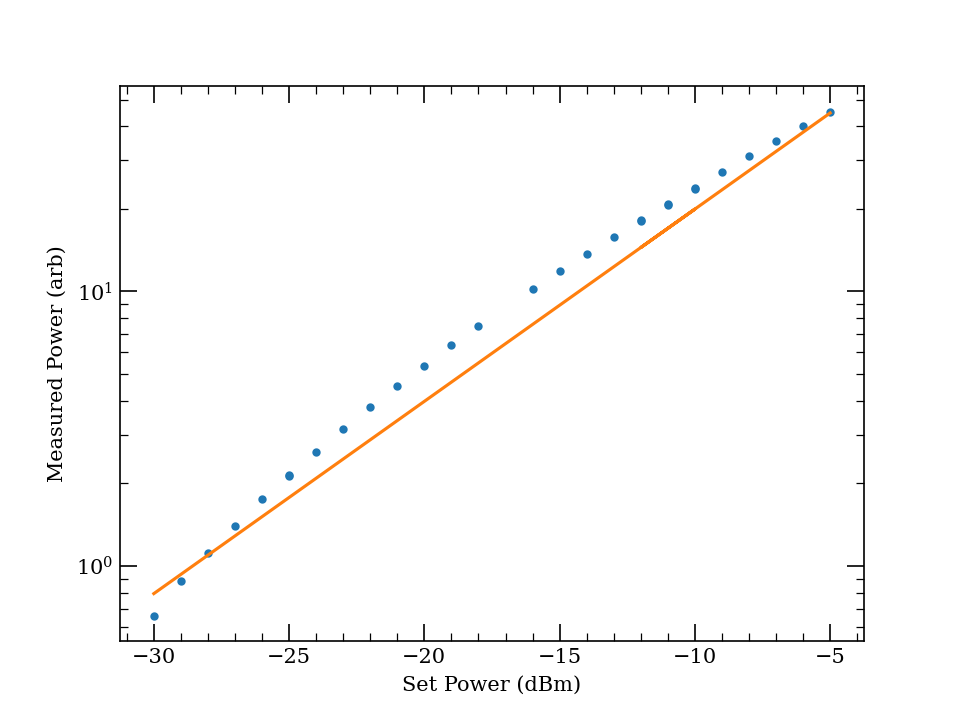

In [19]:
# Failed GOOD logger version of calibration
fn = lambda x, a, s: a*10**(float(s)*x)
fig,ax = plt.subplots(1,1)
ax.plot(dAC_m20["RydDressPower (dBm)"], np.abs(dAC_m20["Measured Dressing Power (arb)"]),".")
xln = np.linspace(min(dAC_m20["RydDressPower (dBm)"]), max(dAC_m20["RydDressPower (dBm)"]), 1000)
ax.plot(dAC_m20["RydDressPower (dBm)"],fn(dAC_m20["RydDressPower (dBm)"],100,0.07))
ax.set_xlabel("Set Power (dBm)")
ax.set_ylabel("Measured Power (arb)")
ax.set_yscale("log")
fig.show()

In [23]:
# Build dataframe that concatenates all data taken at +80MHz intermediate detuning

x_ignores = 2  # ignoring the first n values from the dataset in dAC_2
x_data = np.array(dAC_1["RydDressPower (dBm)"])
x_data = np.append(x_data,dAC_2["RydDressPower (dBm)"][x_ignores:])
print(x_data)

n_bands = 4
dACs = np.zeros((n_bands,len(x_data)),dtype=float)
dACs_er = np.zeros(dACs.shape,dtype=float)

# add data from dataset 1
for band in range(n_bands):
    dACs[band,:len(dAC_1)] = dAC_1[f"Band {band//2} (MHz)"]
    dACs_er[band,:len(dAC_1)] = dAC_1[f"Band {band//2} unc (MHz)"]
    
print(dACs)
dACs = dACs[::-1,:]
# add data from dataset 2
for band in range(n_bands):
    dACs[band,len(dAC_1):] = dAC_2[f"Band {band} (MHz)"][x_ignores:]
    dACs_er[band,len(dAC_1):] = dAC_2[f"Band {band} unc (MHz)"][x_ignores:]

x_data_80 = x_data
dACs_80 = dACs
dACs_80_er = dACs_er

print(dACs_80)

[-30 -29 -28 -27 -26 -25 -24 -23 -21 -20 -19 -18 -17 -16 -15 -14 -13 -12
 -11 -10]
[[-10.95338336 -13.9006255  -17.39611648 -21.71492414 -26.2858261
  -32.34433647 -38.85824904 -46.23017499   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [-10.95338336 -13.9006255  -17.39611648 -21.71492414 -26.2858261
  -32.34433647 -38.85824904 -46.23017499   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [ -6.27336713  -8.18598651 -10.65166557 -13.29963187 -15.93807258
  -20.59398022 -25.66132734 -31.91111693   0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [ -6.27336713  -8.18598651 -10.65166557 -13.29963187 -15.93807258
  -20.59398022 -25.66132734 -31.91111693   0.           0.
    0.           0.           0.  

In [24]:
# Build dataset that concatenates all data taken at +60MHz intermediate detuning

x_data_60 = np.array(dAC_m20["RydDressPower (dBm)"])
x_data_lin = np.abs(np.array(dAC_m20["Measured Dressing Power (arb)"]))
x_lin_std = np.array(dAC_m20["Measured Dressing Power std (arb)"])
dACs_60 = np.zeros((n_bands,len(x_data_60)),dtype=float)
dACs_60_er = np.zeros(dACs_60.shape, dtype=float)
for band in range(n_bands):
    dACs_60[band] = dAC_m20[f"Band {band} (MHz)"]
    dACs_60_er[band] = dAC_m20[f"Band {band} unc (MHz)"]
    
x_cal = cal_fun(x_data_60)

In [25]:
# Select between +60MHz and +80MHz intermediate detuning datasets for all future plotting

dataset = 60  # 80
if dataset == 60:
    last_n = 0
    # exclude last n datapoints for fits
    if last_n > 0:
        x_data = x_cal[:-last_n] # x_data_60[:]
        dACs = dACs_60[:,:-last_n]
        dACs_er = dACs_60_er[:,:-last_n]
        # fraction of dataset excluded from fits to verify extrapolation capability of model
        x_ver = x_cal[-last_n:]#x_data_60[-5:]
        dACs_ver = dACs_60[:,-last_n:]
        dACs_ver_er = dACs_60_er[:,-last_n:]
    else:
        vn = 8
        x_data = x_cal # x_data_60[:]
        dACs = dACs_60
        dACs_er = dACs_60_er
        # fraction of dataset excluded from fits to verify extrapolation capability of model
        x_ver = x_cal[-vn:]
        dACs_ver = dACs_60[:,-vn:]
        dACs_ver_er = dACs_60_er[:,-vn:]
elif dataset == 80:
    x_data = x_data_80
    dACs = dACs_80
    dACs_er = dACs_80_er

In [26]:
dACs_ver.shape

(4, 8)

<IPython.core.display.Javascript object>


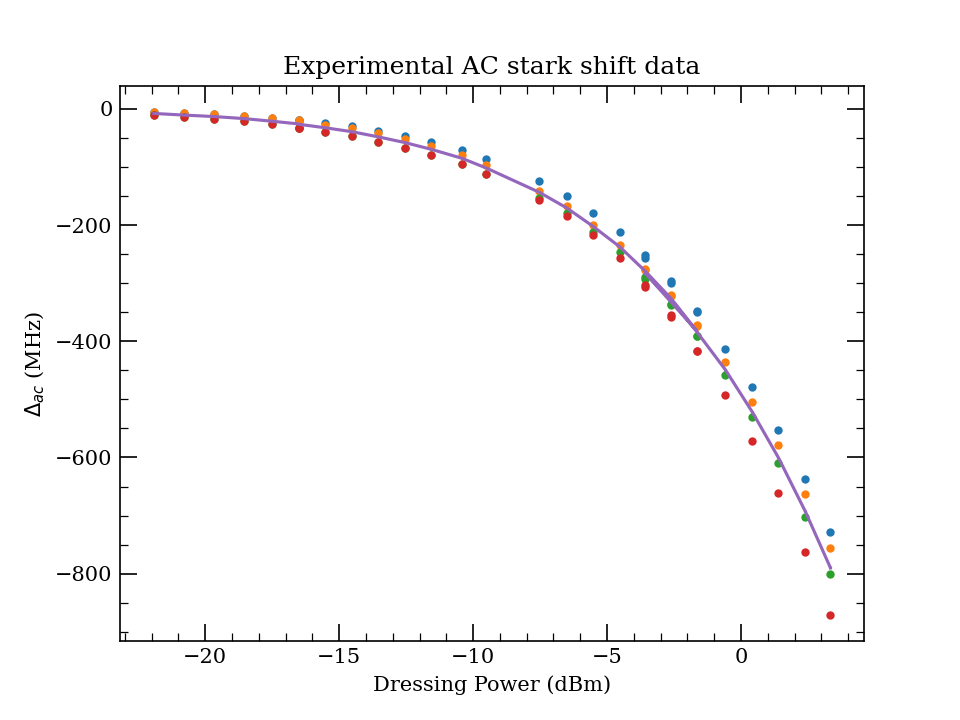

In [27]:
# Plot AC stark shift data and extracted CoG AC stark shift
fig, ax = plt.subplots(1,1)
for band in range(n_bands):
    ax.errorbar(x_data,dACs[band],yerr=dACs_er[band],label=f"Band {band}",fmt=".")
dAC_com = dACs.mean(0)
dAC_com_er = np.sqrt((dACs_er**2).sum(0))
ax.errorbar(x_data,dAC_com,yerr=dAC_com_er)
ax.set_xlabel("Dressing Power (dBm)")
ax.set_ylabel("$\Delta_{ac}$ (MHz)")
ax.set_title("Experimental AC stark shift data")
fig.show()

<IPython.core.display.Javascript object>


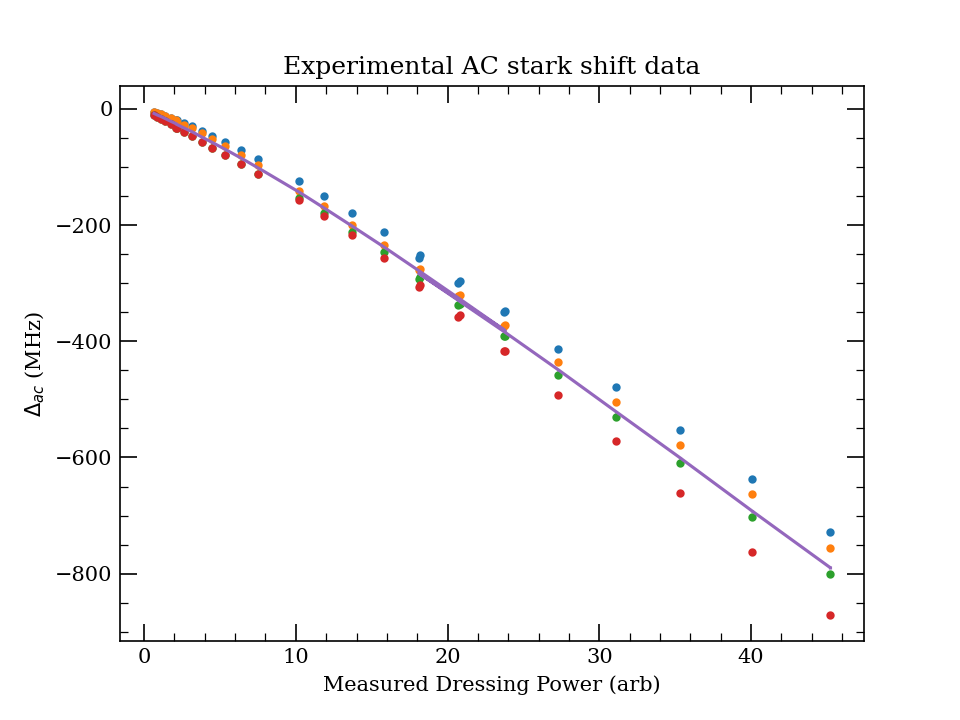

In [28]:
# PLot +60MHz AC stark shifts against measured linearized power
# Failed Attempt! Remove during refactor
fig, ax = plt.subplots(1,1)
for band in range(n_bands):
    ax.errorbar(x_data_lin,dACs[band],yerr=dACs_er[band],xerr=x_lin_std,label=f"Band {band}",fmt=".")
dAC_com = dACs.mean(0)
dAC_com_er = np.sqrt((dACs_er**2).sum(0))
ax.errorbar(x_data_lin,dAC_com,yerr=dAC_com_er)
ax.set_xlabel("Measured Dressing Power (arb)")
ax.set_ylabel("$\Delta_{ac}$ (MHz)")
ax.set_title("Experimental AC stark shift data")
#ax.set_xscale("log")
fig.show()

# Fit CoG AC stark shift to expected behavior

<IPython.core.display.Javascript object>


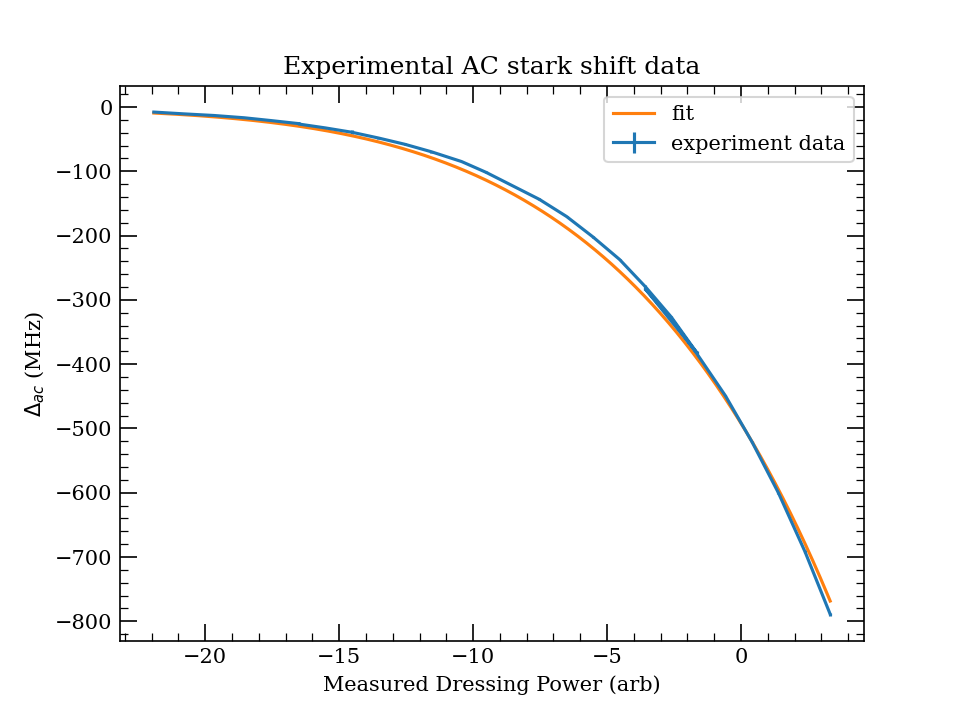

In [29]:
# dB data
func = lambda x, alpha, c: alpha*(np.sqrt(c**2+10**(x/10)) - c)

fig, ax = plt.subplots(1,1)
#for band in range(n_bands):
#    ax.errorbar(x_data_lin,dACs[band],yerr=dACs_er[band],xerr=x_lin_std,label=f"Band {band}",fmt=".")
dAC_com = dACs.mean(0)
dAC_com_er = np.sqrt((dACs_er**2).sum(0))
guess = [-600, 0.2]

xls = np.linspace(min(x_data),max(x_data),1000)
ax.errorbar(x_data,dAC_com,yerr=dAC_com_er, label="experiment data")
ax.plot(xls, func(xls,*guess), label="fit")
ax.set_xlabel("Measured Dressing Power (arb)")
ax.set_ylabel("$\Delta_{ac}$ (MHz)")
ax.set_title("Experimental AC stark shift data")
ax.legend()
#ax.set_xscale("log")
fig.show()

In [30]:
# Use raster scan and rms of residuals to get a rough least-squares fit of data to model

def res(xdat,ydat,func,fit):
    return np.mean(ydat-func(xdat,*fit))

def res_rms(xdat,ydat,func,fit):
    return np.mean(np.sqrt(((ydat-func(xdat,*fit))**2).sum()))

# dB data
func = lambda x, alpha, c: alpha*(np.sqrt(c**2+10**(x/10)) - c)
# linear data
#func = lambda x, alpha, c: alpha*(np.sqrt(c**2+x**2) - c)

xdat = x_data
ydat = dAC_com
yer = dAC_com_er
alphas = -np.linspace(625,680,300)
cs = np.linspace(0.25,0.34,300)
residuals = np.zeros((len(alphas),len(cs)),dtype=float)
residuals_rms = np.zeros((len(alphas),len(cs)),dtype=float)
for i, alpha in enumerate(alphas):
    for j, c in enumerate(cs):
        residuals[i,j] = abs(res(xdat,ydat,func,[alpha,c]))
        residuals_rms[i,j] = res_rms(xdat,ydat,func,[alpha,c])

<IPython.core.display.Javascript object>


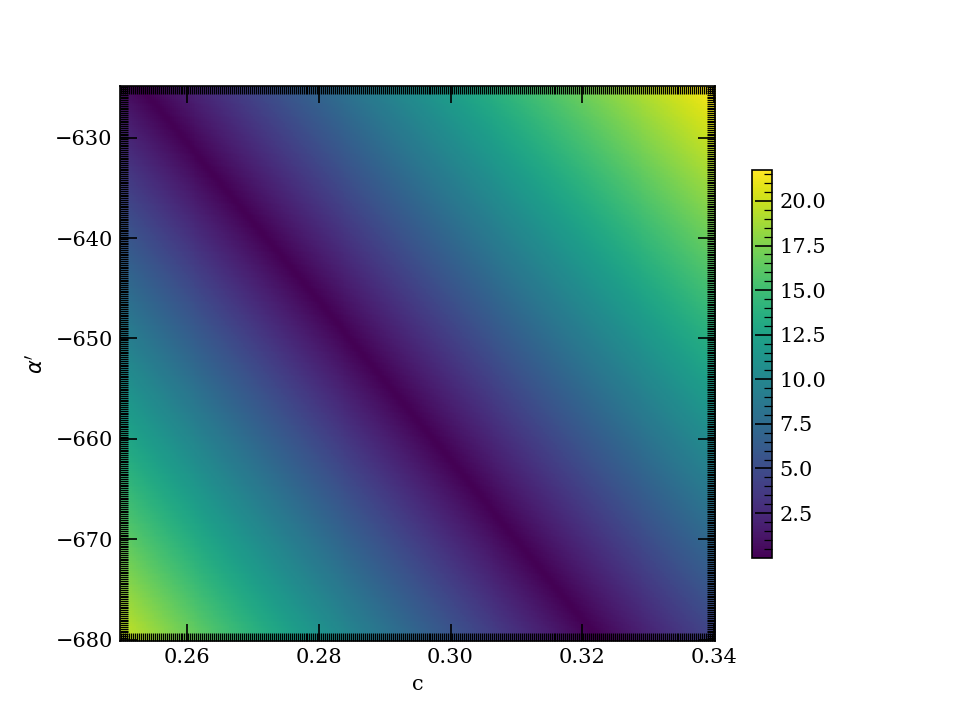

<IPython.core.display.Javascript object>


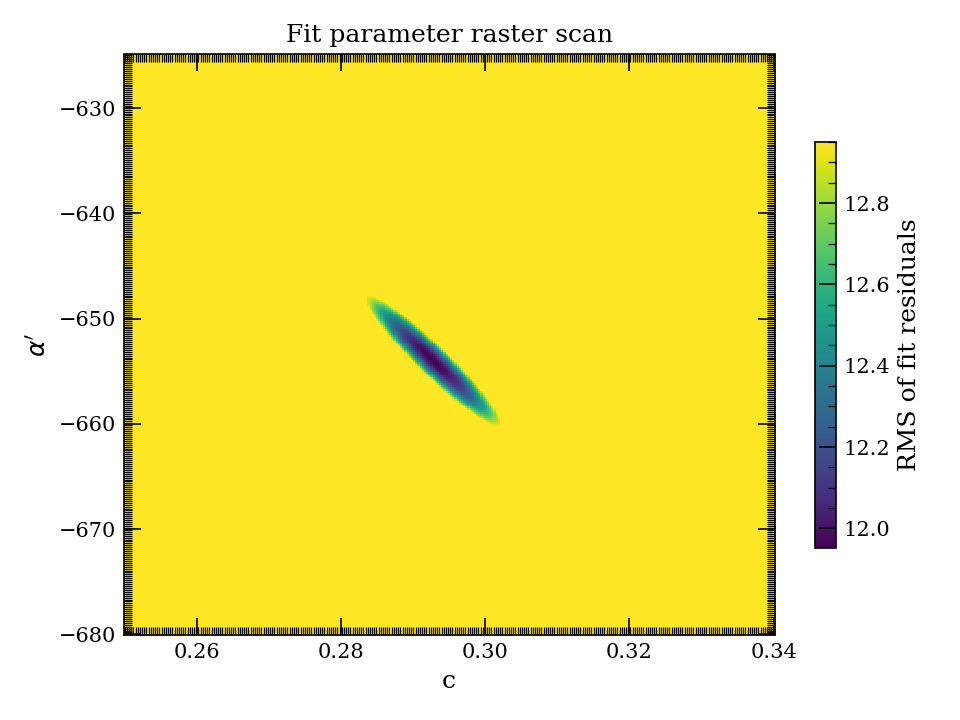

In [31]:
fig,ax = plt.subplots(1,1)
alphas_step = (max(alphas)-min(alphas))/len(alphas)
cs_step = (max(cs)-min(cs))/len(cs)
extent = [
    min(cs)-cs_step/2,
    max(cs)+cs_step/2,
#    max(alphas)+alphas_step/2,
    min(alphas)-alphas_step/2,
    max(alphas)+alphas_step/2,

]
im = ax.imshow(residuals, interpolation="none", aspect="auto", extent=extent)
fig.colorbar(im,ax=ax, use_gridspec=True, shrink=.7)
ax.set_xlabel("c")
ax.set_ylabel("$\\alpha'$")
ax.set_xticks(cs.astype(float),minor=2)
ax.set_yticks(alphas.astype(float),minor=2)
fig.show()

fig,ax = plt.subplots(1,1)
alphas_step = (max(alphas)-min(alphas))/len(alphas)
cs_step = (max(cs)-min(cs))/len(cs)

im = ax.imshow(residuals_rms, interpolation="none", aspect="auto", extent=extent , vmin=np.min(residuals_rms), vmax=np.min(residuals_rms)+1)
cbar = fig.colorbar(im,ax=ax, use_gridspec=True, shrink=.7, label="RMS of residuals")
cbar.set_label("RMS of fit residuals",size=12)
ax.set_xlabel("c")
ax.set_ylabel("$\\alpha'$")
ax.set_xticks(cs.astype(float),minor=2)
ax.set_yticks(alphas.astype(float),minor=2)
ax.set_title("Fit parameter raster scan")
for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("12")

fig.tight_layout()
fig.show()

In [32]:
# extract optimal fitting paramters
good_inds = np.argwhere(residuals_rms == np.min(residuals_rms))[0]
fits = alphas[good_inds[0]],cs[good_inds[1]]
print(good_inds)
print(fits)

[157 141]
(-653.8795986622074, 0.29244147157190636)


<IPython.core.display.Javascript object>


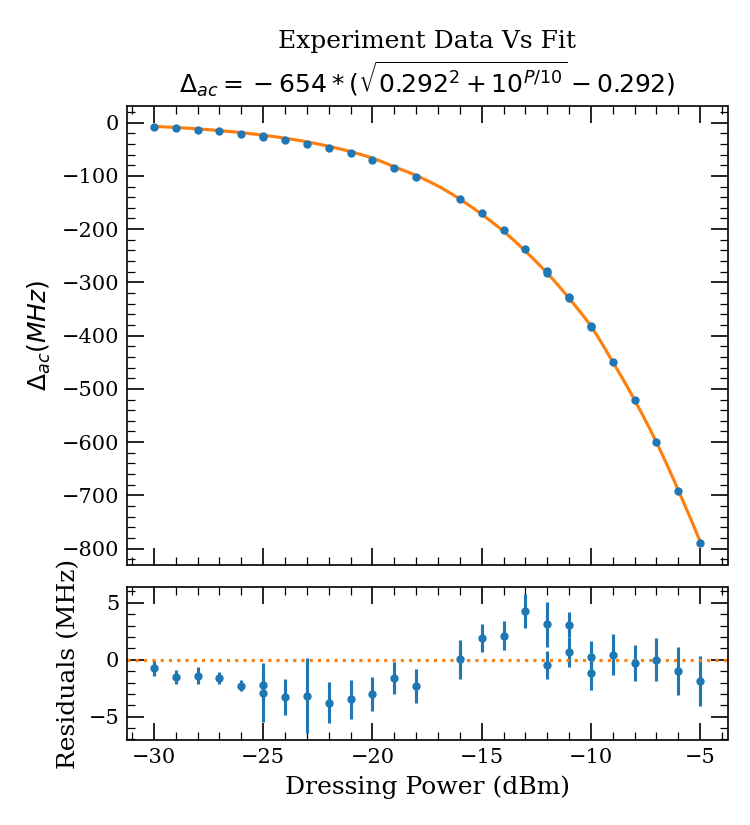

In [33]:
results_dir = r"Shirley-Floquet_results\PolarizabilityPlots\RawData"
plots_dir =  r"Shirley-Floquet_results\PolarizabilityPlots"

# plot data against CoG fit
#func = lambda x, alpha, c: alpha*(np.sqrt(c**2+10**(x/10)) - c)
inv_cal = interp1d(y_pk, x_set, kind="linear")

guess = fits

fig,axar = plt.subplots(2,1,figsize=(5,5.5),gridspec_kw={'height_ratios': [3, 1]})#,sharex=True)

ax=axar[0]
ax.errorbar(inv_cal(xdat),ydat,yerr=yer,fmt=".")
xlin=np.linspace(min(xdat),max(xdat),1000)
ax.plot(inv_cal(xlin),func(xlin,*guess))
ax.set_title(f"Experiment Data Vs Fit\n$\Delta_{{ac}} = {guess[0]:.0f}*(\sqrt{{{guess[1]:.3f}^2+10^{{P/10}} }} - {guess[1]:.3f})$")
#ax.set_title(f"Experiment Data Vs Fit\n$\Delta_{{ac}} = {guess[0]:.0f}*(\sqrt{{{guess[1]:.3f}^2+P^2}} - {guess[1]:.3f})$")
#ax.set_xlabel("Dressing Power (dBm)")
#ax.set_xlabel("Dressing Power Measured (arb)")
ax.set_ylabel("$\Delta_{ac} (MHz)$")

ax=axar[1]
ax.errorbar(inv_cal(xdat),ydat-func(xdat,*guess),yerr=yer,fmt=".")
ax.axhline(0,ls=":",c="tab:orange")
#ax.set_title("Fit Residuals")
ax.set_ylabel("Residuals (MHz)")
ax.set_xlabel("Dressing Power (dBm)")
#ax.set_xlabel("Dressing Power Measured (arb)")
#ax.plot(xlin,func(xlin,*guess))
axar[0].get_shared_x_axes().join(axar[0], axar[1])
axar[0].set_xticklabels([])
axar[1].set_xlim(axar[0].get_xlim())

for ax in axar:
    for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
        txt.set_fontsize("12")
fig.tight_layout()
fig.savefig(os.path.join(plots_dir,"UnitlessCoMFit.png"))
fig.show()

In [35]:
# estimate sensitivity to a 0.1dBm miscalibration of Dressing Power
a = fits[0]
c = fits[1]
func = lambda x, alpha, c: alpha*(np.sqrt(c**2+10**(x/10)) - c)
dfunc = lambda x, alpha, c: -alpha*2**(x/10-2)*5**(x/10-1)*np.log(10)/np.sqrt(c**2+10**(x/10))

sens = 0.1*dfunc(-10.289,1589,0.095) # MHz

# Scan Eac to match up numerical estimates with experimental data

In [36]:
levels, basis, basis_n = None, None, None
ellipticity, scale = None, None

In [37]:
fields = {
    "Eac": np.append(np.linspace(0,15,200),np.linspace(15+75/300,90,350)),
#    "Eac": 80,
#    "ellipticity": np.linspace(0,np.sqrt(0.04),200)**2,
    "ellipticity": 0.012,
    "field_omega": tau*4780e6,
    "Edc": 0.0,
    "theta": 0
}

for key, value in fields.items():
    try:
        tmp = value[1]
    except TypeError:
        continue
    else:
        varied = (key, value)

t_level = RydStateFS(52,1,3/2)
max_det = tau*30e9
dl = 2
n_max = 2

comp = {"n_max": n_max, "dl": dl, "max_det": max_det}

if levels is None:
    levels, basis = build_basis(t_level, max_det, single_side=False, dl=dl)
    basis_n = build_n_basis(basis, n_max)
    
t_inds = [ind for ind, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]

# measured properties

# for 685nm at +60MHz wrt 4-6' transition. Generator at 181.25MHz
if dataset == 60:
    # measured resonance between nP3/2 -> nD3/2 levels
    p3o2_d3o2_res = 4839*1e6*tau
# for 685nm at +80MHz wrt 4-6' transition. Generator at 191.25MHz
elif dataset == 80:
    p3o2_d3o2_res = 4840*1e6*tau
# effective laser induced AC stark shift
laser_dAC = detuning(RydStateFS(51,2,3/2), t_level, p3o2_d3o2_res)

## Single Scan

In [25]:
#ellips = arange(0.015,0.024,0.001)
#scales = linspace(150,180,100)
H0 = build_H0(basis, t_level, offset_zeeman=1e6)
H0[t_inds,t_inds] += laser_dAC
f_inds = [(ind,state.j) for ind, state in enumerate(basis) if state.l == 2]
f_jsplit = 3e6
for ind, j in f_inds:
    H0[ind,ind] += f_jsplit*j
#for ellip in ellips: 
#    fields["ellipticity"] = ellip
try:
    del energies
    del eigenstates
except NameError:
    pass
energies, eigenstates, error = floquet_loop(basis, H0, n_max=n_max, varied=varied, energy_bands=True, **fields)

if error is not None:
    print(error)
#    basis_t = [i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
#    dAC_num = energies
    
#    for scale in scales:
        

240
Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.02031564712524414
Hdc built in 0.000997304916381836
Hfloquet put together in 0.0
Floquet matrix built after 0.021312952041625977 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 0.0, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.00799250602722168s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.029305458068847656s
Diagonalization complete for independent variable entry, value 0, 0.0
finding good eigenvectors for |level, n> = ||52,S,1/2>,-2>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,0>
finding good eigenvectors for |level, n> = ||52,S,1/2>,1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,2>
finding good eigenvectors for |level

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 0.6783919597989949, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.32520341873168945s
Normalization Complete after 0.015328645706176758 s
floquet_diag call completed in 0.36791062355041504s
Diagonalization complete for independent variable entry, value 9, 0.6783919597989949
re-arrangement done after time 0.003620147705078125s
little_d built in 0.0156857967376709
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.017369985580444336 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 0.7537688442211055, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.32877111434936523s
Normalization Complete after 0.002317190170288086 s
floquet_diag call completed in 0.34845829010009766s
Diagonalization complete for independent variable entry, value 10, 0.7537688442

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 1.7336683417085426, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33350229263305664s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.34912824630737305s
Diagonalization complete for independent variable entry, value 23, 1.7336683417085426
re-arrangement done after time 0.015625715255737305s
little_d built in 0.016157865524291992
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.016157865524291992 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 1.809045226130653, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3327937126159668s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.3489515781402588s
Diagonalization complete for independent variable entry, value 24, 1.809045226130653
re-arrangement done after ti

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 2.8643216080402008, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.32024097442626953s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.35149431228637695s
Diagonalization complete for independent variable entry, value 38, 2.8643216080402008
re-arrangement done after time 0.0s
little_d built in 0.025656461715698242
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.025656461715698242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 2.9396984924623113, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33200860023498535s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.3576650619506836s
Diagonalization complete for independent variable entry, value 39, 2.9396984924623113
re-arrangement done after time 0.018997430

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 3.9195979899497484, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.32381248474121094s
Normalization Complete after 0.0019981861114501953 s
floquet_diag call completed in 0.34296512603759766s
Diagonalization complete for independent variable entry, value 52, 3.9195979899497484
re-arrangement done after time 0.00599980354309082s
little_d built in 0.013000011444091797
Hdc built in 0.0010001659393310547
Hfloquet put together in 0.0
Floquet matrix built after 0.015000104904174805 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 3.994974874371859, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3297007083892822s
Normalization Complete after 0.006000518798828125 s
floquet_diag call completed in 0.35070133209228516s
Diagonalization complete for independent variable entry, val

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 4.974874371859296, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3343524932861328s
Normalization Complete after 0.005911588668823242 s
floquet_diag call completed in 0.357013463973999s
Diagonalization complete for independent variable entry, value 66, 4.974874371859296
re-arrangement done after time 0.00963592529296875s
little_d built in 0.01897907257080078
Hdc built in 0.0010089874267578125
Hfloquet put together in 0.0009984970092773438
Floquet matrix built after 0.020986557006835938 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 5.050251256281406, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3195321559906006s
Normalization Complete after 0.007038593292236328 s
floquet_diag call completed in 0.34755730628967285s
Diagonalization complete for independent variable

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 5.954773869346733, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.32479405403137207s
Normalization Complete after 0.006995201110839844 s
floquet_diag call completed in 0.34679579734802246s
Diagonalization complete for independent variable entry, value 79, 5.954773869346733
re-arrangement done after time 0.005270481109619141s
little_d built in 0.012614965438842773
Hdc built in 0.0010044574737548828
Hfloquet put together in 0.0
Floquet matrix built after 0.014619588851928711 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 6.030150753768844, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.321502685546875s
Normalization Complete after 0.0069980621337890625 s
floquet_diag call completed in 0.3431203365325928s
Diagonalization complete for independent variable entry, value 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 7.010050251256281, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3315858840942383s
Normalization Complete after 0.005102634429931641 s
floquet_diag call completed in 0.35220956802368164s
Diagonalization complete for independent variable entry, value 93, 7.010050251256281
re-arrangement done after time 0.006693840026855469s
little_d built in 0.010521888732910156
Hdc built in 0.0016894340515136719
Hfloquet put together in 0.0005059242248535156
Floquet matrix built after 0.012717247009277344 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 7.085427135678391, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3333158493041992s
Normalization Complete after 0.005515336990356445 s
floquet_diag call completed in 0.35254693031311035s
Diagonalization complete for independent vari

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 8.065326633165828, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3240773677825928s
Normalization Complete after 0.006015777587890625 s
floquet_diag call completed in 0.3483245372772217s
Diagonalization complete for independent variable entry, value 107, 8.065326633165828
re-arrangement done after time 0.0s
little_d built in 0.02006363868713379
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.02006363868713379 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 8.140703517587939, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3203127384185791s
Normalization Complete after 0.012739896774291992 s
floquet_diag call completed in 0.3541219234466553s
Diagonalization complete for independent variable entry, value 108, 8.140703517587939
re-arrangement 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 9.120603015075377, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33992528915405273s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.3586721420288086s
Diagonalization complete for independent variable entry, value 121, 9.120603015075377
re-arrangement done after time 0.003067493438720703s
little_d built in 0.008692264556884766
Hdc built in 0.0070226192474365234
Hfloquet put together in 0.0
Floquet matrix built after 0.017245769500732422 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 9.195979899497488, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3307380676269531s
Normalization Complete after 0.010217905044555664 s
floquet_diag call completed in 0.3582017421722412s
Diagonalization complete for independent variable entry, value 122, 9.1959798994

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 10.175879396984923, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33062744140625s
Normalization Complete after 0.010072469711303711 s
floquet_diag call completed in 0.36208486557006836s
Diagonalization complete for independent variable entry, value 135, 10.175879396984923
re-arrangement done after time 0.0s
little_d built in 0.01788043975830078
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.01788043975830078 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 10.251256281407034, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3302273750305176s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.34810781478881836s
Diagonalization complete for independent variable entry, value 136, 10.251256281407034
re-arrangement done after ti

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 11.231155778894472, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33066892623901367s
Normalization Complete after 0.005052804946899414 s
floquet_diag call completed in 0.3552825450897217s
Diagonalization complete for independent variable entry, value 149, 11.231155778894472
re-arrangement done after time 0.007624387741088867s
little_d built in 0.00773930549621582
Hdc built in 0.006551265716552734
Hfloquet put together in 0.0
Floquet matrix built after 0.014290571212768555 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 11.306532663316581, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3627481460571289s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.37703871726989746s
Diagonalization complete for independent variable entry, value 150, 11.3065326

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 12.286432160804019, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3350837230682373s
Normalization Complete after 0.0048868656158447266 s
floquet_diag call completed in 0.3573312759399414s
Diagonalization complete for independent variable entry, value 163, 12.286432160804019
re-arrangement done after time 0.008580207824707031s
little_d built in 0.011490106582641602
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.011490106582641602 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 12.36180904522613, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.32959556579589844s
Normalization Complete after 0.010255813598632812 s
floquet_diag call completed in 0.35134148597717285s
Diagonalization complete for independent variable entry, value 164, 12.361809

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 13.341708542713567, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3495030403137207s
Normalization Complete after 0.008950233459472656 s
floquet_diag call completed in 0.368755578994751s
Diagonalization complete for independent variable entry, value 177, 13.341708542713567
re-arrangement done after time 0.004049062728881836s
little_d built in 0.009057283401489258
Hdc built in 0.0
Hfloquet put together in 0.007055521011352539
Floquet matrix built after 0.016112804412841797 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 13.417085427135678, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3308982849121094s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.3563523292541504s
Diagonalization complete for independent variable entry, value 178, 13.417085427

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 14.396984924623114, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3501698970794678s
Normalization Complete after 0.005574464797973633 s
floquet_diag call completed in 0.3750128746032715s
Diagonalization complete for independent variable entry, value 191, 14.396984924623114
re-arrangement done after time 0.0045528411865234375s
little_d built in 0.011132478713989258
Hdc built in 0.00753021240234375
Hfloquet put together in 0.0
Floquet matrix built after 0.019712209701538086 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 14.472361809045225, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3401961326599121s
Normalization Complete after 0.01003575325012207 s
floquet_diag call completed in 0.36994409561157227s
Diagonalization complete for independent variable entry, value

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 16.320916905444125, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3300004005432129s
Normalization Complete after 0.010072946548461914 s
floquet_diag call completed in 0.3601951599121094s
Diagonalization complete for independent variable entry, value 205, 16.320916905444125
re-arrangement done after time 0.0s
little_d built in 0.014901876449584961
Hdc built in 0.005025386810302734
Hfloquet put together in 0.0
Floquet matrix built after 0.019927263259887695 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 16.535100286532952, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3500640392303467s
Normalization Complete after 0.0065364837646484375 s
floquet_diag call completed in 0.3765277862548828s
Diagonalization complete for independent variable entry, value 206, 16.5351002

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 19.31948424068768, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3304426670074463s
Normalization Complete after 0.008536100387573242 s
floquet_diag call completed in 0.35227346420288086s
Diagonalization complete for independent variable entry, value 219, 19.31948424068768
re-arrangement done after time 0.001055002212524414s
little_d built in 0.014629364013671875
Hdc built in 0.005358457565307617
Hfloquet put together in 0.0
Floquet matrix built after 0.019987821578979492 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 19.533667621776505, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34120726585388184s
Normalization Complete after 0.008525609970092773 s
floquet_diag call completed in 0.3697206974029541s
Diagonalization complete for independent variable entry, value

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 22.318051575931232, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3515310287475586s
Normalization Complete after 0.013058662414550781 s
floquet_diag call completed in 0.3838224411010742s
Diagonalization complete for independent variable entry, value 233, 22.318051575931232
re-arrangement done after time 0.006272077560424805s
little_d built in 0.012635469436645508
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.012635469436645508 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 22.53223495702006, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3367490768432617s
Normalization Complete after 0.012044429779052734 s
floquet_diag call completed in 0.36142897605895996s
Diagonalization complete for independent variable entry, value 234, 22.53223495

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 25.316618911174785, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3507061004638672s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.3659482002258301s
Diagonalization complete for independent variable entry, value 247, 25.316618911174785
re-arrangement done after time 0.011150598526000977s
little_d built in 0.01729559898376465
Hdc built in 0.0010204315185546875
Hfloquet put together in 0.0
Floquet matrix built after 0.018316030502319336 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 25.53080229226361, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3488609790802002s
Normalization Complete after 0.001409292221069336 s
floquet_diag call completed in 0.36858630180358887s
Diagonalization complete for independent variable entry, value 248, 25.53080229

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 28.315186246418335, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3290383815765381s
Normalization Complete after 0.012705326080322266 s
floquet_diag call completed in 0.3614771366119385s
Diagonalization complete for independent variable entry, value 261, 28.315186246418335
re-arrangement done after time 0.005829572677612305s
little_d built in 0.012289762496948242
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.012289762496948242 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 28.52936962750716, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.36075592041015625s
Normalization Complete after 0.007520437240600586 s
floquet_diag call completed in 0.3805661201477051s
Diagonalization complete for independent variable entry, value 262, 28.52936962

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 31.31375358166189, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33957743644714355s
Normalization Complete after 0.010040760040283203 s
floquet_diag call completed in 0.36894822120666504s
Diagonalization complete for independent variable entry, value 275, 31.31375358166189
re-arrangement done after time 0.0s
little_d built in 0.019785642623901367
Hdc built in 0.0006110668182373047
Hfloquet put together in 0.0
Floquet matrix built after 0.020396709442138672 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 31.527936962750715, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33925867080688477s
Normalization Complete after 0.004015445709228516 s
floquet_diag call completed in 0.36367082595825195s
Diagonalization complete for independent variable entry, value 276, 31.52793

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 34.31232091690544, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3301057815551758s
Normalization Complete after 0.009531497955322266 s
floquet_diag call completed in 0.34935426712036133s
Diagonalization complete for independent variable entry, value 289, 34.31232091690544
re-arrangement done after time 0.009059906005859375s
little_d built in 0.01213383674621582
Hdc built in 0.0
Hfloquet put together in 0.005510568618774414
Floquet matrix built after 0.017644405364990234 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 34.526504297994265, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3528454303741455s
Normalization Complete after 0.010679244995117188 s
floquet_diag call completed in 0.38116908073425293s
Diagonalization complete for independent variable entry, value 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 37.310888252149, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33796143531799316s
Normalization Complete after 0.008818387985229492 s
floquet_diag call completed in 0.3599274158477783s
Diagonalization complete for independent variable entry, value 303, 37.310888252149
re-arrangement done after time 0.00508570671081543s
little_d built in 0.009070634841918945
Hdc built in 0.0010194778442382812
Hfloquet put together in 0.0005764961242675781
Floquet matrix built after 0.01569676399230957 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 37.52507163323782, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33949732780456543s
Normalization Complete after 0.011565446853637695 s
floquet_diag call completed in 0.3667595386505127s
Diagonalization complete for independent variable 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 40.30945558739255, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3327975273132324s
Normalization Complete after 0.0075283050537109375 s
floquet_diag call completed in 0.3508172035217285s
Diagonalization complete for independent variable entry, value 317, 40.30945558739255
re-arrangement done after time 0.0s
little_d built in 0.01920342445373535
Hdc built in 0.0005841255187988281
Hfloquet put together in 0.0
Floquet matrix built after 0.01978754997253418 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 40.52363896848138, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3200235366821289s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.3485579490661621s
Diagonalization complete for independent variable entry, value 318, 40.52363896848138
re-arrangemen

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 43.3080229226361, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3496387004852295s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.3695094585418701s
Diagonalization complete for independent variable entry, value 331, 43.3080229226361
re-arrangement done after time 0.011228561401367188s
little_d built in 0.01333761215209961
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.01333761215209961 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 43.52220630372493, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34874868392944336s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.36208629608154297s
Diagonalization complete for independent variable entry, value 332, 43.52220630372493
re-arrangement done after time 0

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.306590257879655, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33408451080322266s
Normalization Complete after 0.008925914764404297 s
floquet_diag call completed in 0.3548874855041504s
Diagonalization complete for independent variable entry, value 345, 46.306590257879655
re-arrangement done after time 0.006038188934326172s
little_d built in 0.009076118469238281
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.009076118469238281 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.52077363896848, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3399968147277832s
Normalization Complete after 0.010567188262939453 s
floquet_diag call completed in 0.35964012145996094s
Diagonalization complete for independent variable entry, value 346, 46.5207736

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 49.305157593123205, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3260958194732666s
Normalization Complete after 0.004419088363647461 s
floquet_diag call completed in 0.3401045799255371s
Diagonalization complete for independent variable entry, value 359, 49.305157593123205
re-arrangement done after time 0.007021188735961914s
little_d built in 0.013356924057006836
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.013356924057006836 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 49.519340974212035, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33975672721862793s
Normalization Complete after 0.009565591812133789 s
floquet_diag call completed in 0.36267924308776855s
Diagonalization complete for independent variable entry, value 360, 49.519340

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 52.30372492836676, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33046460151672363s
Normalization Complete after 0.005514621734619141 s
floquet_diag call completed in 0.355670690536499s
Diagonalization complete for independent variable entry, value 373, 52.30372492836676
re-arrangement done after time 0.004034757614135742s
little_d built in 0.011793136596679688
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.011793136596679688 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 52.517908309455585, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3282289505004883s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.34002208709716797s
Diagonalization complete for independent variable entry, value 374, 52.517908309455585
re-arrange

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 55.30229226361031, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33976292610168457s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.35975170135498047s
Diagonalization complete for independent variable entry, value 387, 55.30229226361031
re-arrangement done after time 0.0s
little_d built in 0.01183176040649414
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.01183176040649414 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 55.516475644699135, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3231394290924072s
Normalization Complete after 0.010045766830444336 s
floquet_diag call completed in 0.3450169563293457s
Diagonalization complete for independent variable entry, value 388, 55.516475644699135
re-arrangement done after ti

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 58.30085959885387, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34128856658935547s
Normalization Complete after 0.004018068313598633 s
floquet_diag call completed in 0.36367225646972656s
Diagonalization complete for independent variable entry, value 401, 58.30085959885387
re-arrangement done after time 0.009699106216430664s
little_d built in 0.014979839324951172
Hdc built in 0.0010347366333007812
Hfloquet put together in 0.0
Floquet matrix built after 0.01666569709777832 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 58.51504297994269, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34924864768981934s
Normalization Complete after 0.010211944580078125 s
floquet_diag call completed in 0.3766021728515625s
Diagonalization complete for independent variable entry, value

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 61.29942693409742, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3412282466888428s
Normalization Complete after 0.00943446159362793 s
floquet_diag call completed in 0.36078429222106934s
Diagonalization complete for independent variable entry, value 415, 61.29942693409742
re-arrangement done after time 0.004012346267700195s
little_d built in 0.015315532684326172
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.015905380249023438 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 61.51361031518624, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3492128849029541s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.36511826515197754s
Diagonalization complete for independent variable entry, value 416, 61.51361031518624
re-arrangeme

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 64.29799426934096, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3310816287994385s
Normalization Complete after 0.00902557373046875 s
floquet_diag call completed in 0.35930538177490234s
Diagonalization complete for independent variable entry, value 429, 64.29799426934096
re-arrangement done after time 0.0s
little_d built in 0.013957977294921875
Hdc built in 0.006371498107910156
Hfloquet put together in 0.0
Floquet matrix built after 0.02032947540283203 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 64.5121776504298, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33064961433410645s
Normalization Complete after 0.002016782760620117 s
floquet_diag call completed in 0.3595254421234131s
Diagonalization complete for independent variable entry, value 430, 64.512177650429

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 67.29656160458453, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34206342697143555s
Normalization Complete after 0.007472038269042969 s
floquet_diag call completed in 0.36373138427734375s
Diagonalization complete for independent variable entry, value 443, 67.29656160458453
re-arrangement done after time 0.0065572261810302734s
little_d built in 0.010710716247558594
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010710716247558594 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 67.51074498567334, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.35350728034973145s
Normalization Complete after 0.00589442253112793 s
floquet_diag call completed in 0.37011241912841797s
Diagonalization complete for independent variable entry, value 444, 67.5107449

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 70.29512893982807, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.32987260818481445s
Normalization Complete after 0.010132789611816406 s
floquet_diag call completed in 0.36017918586730957s
Diagonalization complete for independent variable entry, value 457, 70.29512893982807
re-arrangement done after time 0.00838327407836914s
little_d built in 0.011674642562866211
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.011674642562866211 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 70.5093123209169, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.338958740234375s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.35866641998291016s
Diagonalization complete for independent variable entry, value 458, 70.5093123209169
re-arrangement

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 73.29369627507162, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3376584053039551s
Normalization Complete after 0.009035825729370117 s
floquet_diag call completed in 0.3598663806915283s
Diagonalization complete for independent variable entry, value 471, 73.29369627507162
re-arrangement done after time 0.004965543746948242s
little_d built in 0.009625434875488281
Hdc built in 0.004507541656494141
Hfloquet put together in 0.0
Floquet matrix built after 0.014132976531982422 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 73.50787965616045, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3457002639770508s
Normalization Complete after 0.005517721176147461 s
floquet_diag call completed in 0.36535096168518066s
Diagonalization complete for independent variable entry, value 4

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 76.29226361031519, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33965373039245605s
Normalization Complete after 0.0045166015625 s
floquet_diag call completed in 0.3648674488067627s
Diagonalization complete for independent variable entry, value 485, 76.29226361031519
re-arrangement done after time 0.005073070526123047s
little_d built in 0.01088714599609375
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.01088714599609375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 76.506446991404, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3427910804748535s
Normalization Complete after 0.006517171859741211 s
floquet_diag call completed in 0.3601953983306885s
Diagonalization complete for independent variable entry, value 486, 76.506446991404
re-arr

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 79.29083094555874, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.334491491317749s
Normalization Complete after 0.005518198013305664 s
floquet_diag call completed in 0.35401248931884766s
Diagonalization complete for independent variable entry, value 499, 79.29083094555874
re-arrangement done after time 0.0s
little_d built in 0.019844770431518555
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.019844770431518555 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 79.50501432664755, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33986997604370117s
Normalization Complete after 0.010596513748168945 s
floquet_diag call completed in 0.37031126022338867s
Diagonalization complete for independent variable entry, value 500, 79.50501432664755
re-arrangem

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 82.28939828080229, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34320974349975586s
Normalization Complete after 0.004016399383544922 s
floquet_diag call completed in 0.3629608154296875s
Diagonalization complete for independent variable entry, value 513, 82.28939828080229
re-arrangement done after time 0.006674766540527344s
little_d built in 0.01186227798461914
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.01186227798461914 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 82.50358166189112, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34497666358947754s
Normalization Complete after 0.002941131591796875 s
floquet_diag call completed in 0.35978007316589355s
Diagonalization complete for independent variable entry, value 514, 82.5035816618

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 85.28796561604584, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33104681968688965s
Normalization Complete after 0.004518032073974609 s
floquet_diag call completed in 0.34917783737182617s
Diagonalization complete for independent variable entry, value 527, 85.28796561604584
re-arrangement done after time 0.009706258773803711s
little_d built in 0.009808778762817383
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.009808778762817383 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 85.50214899713467, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33037877082824707s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.34018754959106445s
Diagonalization complete for independent variable entry, value 528, 85.50214899713467
re-arrang

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 88.28653295128939, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.32037997245788574s
Normalization Complete after 0.0015184879302978516 s
floquet_diag call completed in 0.34055638313293457s
Diagonalization complete for independent variable entry, value 541, 88.28653295128939
re-arrangement done after time 0.012240409851074219s
little_d built in 0.006821393966674805
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.006821393966674805 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 88.50071633237822, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3394510746002197s
Normalization Complete after 0.005021333694458008 s
floquet_diag call completed in 0.35129380226135254s
Diagonalization complete for independent variable entry, value 542, 88.5007163

## Iterative scans
Repeat raster-scan to least-squares fit technique from CoG fit above

In [ ]:
ellips = np.arange(0.01125,0.0125,0.00025)
scales = np.arange(63,65,0.01)
#scales=[167]
residuals = np.zeros((len(ellips),len(scales)), dtype=float)
residuals_rms = np.zeros(residuals.shape, dtype=float)
H0 = build_H0(basis, t_level, offset_zeeman=1e6)
H0[t_inds,t_inds] += laser_dAC
f_inds = [(ind,state.j) for ind, state in enumerate(basis) if state.l == 2]
f_jsplit = 3e6
for ind, j in f_inds:
    H0[ind,ind] += f_jsplit*j

basis_t = [i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
#Reorder experiment bands
tmp = basis_t[1]
basis_t[1] = basis_t[2]
basis_t[2] = tmp
basis_t = basis_t[1:] + basis_t[:1]
basis_t = basis_t[::-1]

for i, ellip in enumerate(ellips):
    try:
        del energies
        del eigenstates
    except NameError:
        pass
    fields["ellipticity"] = ellip
    energies, eigenstates = floquet_loop(basis, H0, n_max=n_max, varied=varied, energy_bands=True, **fields)

    dAC_num = energies
    
    for j, scale in enumerate(scales):
        x_ac = 20*np.log10(varied[1]/scale)
        #fig, axar = plt.subplots(1,2,figsize=(12,6))
        #ax=axar[0]
        #ax1=axar[1]
        for band in range(n_bands):
            y_num = 1e-6*(energies[basis_t[::-1][band]]-energies[basis_t[::-1][band],0])/tau
            y_ex = dACs[band]
            dy_er = dACs_er[band]
            #ax.plot(x_ac,y_num,label=f"numerical band {band}")
            #ax.errorbar(x_data,y_ex,yerr=dy_er,fmt=".",label=f"experimental band {band}")
            y_int = np.interp(x_data,x_ac,y_num)
            res = y_ex-y_int
            #ax1.errorbar(x_data,res,yerr=dy_er,fmt=".",label=f"Band {band}")
            residuals[i,j] += res.mean()
            residuals_rms[i,j] = np.sqrt(residuals_rms[i,j]**2+(res**2).sum())
        '''ax.set_title(f"AC stark shift CoM fit\n$\omega_{{d}}=2\pi \cdot 4780MHz$\n$\epsilon={ellip:.3f}; V_{{ref}} = {scale:.0f}V/m$")
        ax.set_xlabel("Dressing Power (dBm)")
        ax.set_ylabel("$\Delta_{ac}-CoM (MHz)$")
        ax.set_xlim(-31,-9)
        ax.legend(loc=3)
        ax1.set_title("Fit residuals")
        ax1.set_xlabel("Dressing Power (dBm)")
        ax1.set_ylabel("Fit Residuals (MHz)")
        fig.show'''

In [ ]:
fig,ax = plt.subplots(1,1)
eps_step = (max(ellips)-min(ellips))/len(ellips)
scale_step = (max(scales)-min(scales))/len(scales)
extent = [
    min(scales)-scale_step/2,
    max(scales)+scale_step/2,
    max(ellips)+eps_step/2,
    min(ellips)-eps_step/2,

]
im = ax.imshow(residuals, interpolation="none", aspect="auto", extent=extent)
fig.colorbar(im,ax=ax, use_gridspec=True, shrink=.7)
ax.set_xlabel("$V_{ref}$")
ax.set_ylabel("$\epsilon$")
ax.set_xticks(scales.astype(float),minor=2)
ax.set_yticks(ellips.astype(float),minor=2)
fig.show()

fig,ax = plt.subplots(1,1)
im = ax.imshow(residuals_rms, interpolation="none", aspect="auto", extent=extent, vmin=np.min(residuals_rms), vmax=np.min(residuals_rms)+1)
cbar = fig.colorbar(im,ax=ax, use_gridspec=True, shrink=.7, label="RMS of residuals")
cbar.set_label("RMS of fit residuals",size=12)
ax.set_xlabel("$V_{ref}$")
ax.set_ylabel("$\epsilon$")
ax.set_xticks(scales.astype(float),minor=2)
ax.set_yticks(ellips.astype(float),minor=2)
ax.set_title("Fit parameter raster scan")
for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("12")

fig.tight_layout()
fig.show()

In [ ]:
# Extract fit parameters
good_inds = np.argwhere(residuals_rms == np.min(residuals_rms))[0]
ellipticity = float(ellips[good_inds[0]])
scale = float(scales[good_inds[1]])
print(np.argwhere(residuals_rms == np.min(residuals_rms)))
print(ellipticity, scale)
# delete large residuals arrays to make space for final scan
del residuals
del residuals_rms

In [41]:
# manually enter optimal fit values if known, to avoid running raster scan each time
if dataset == 60:
    # ellipticity = 0.0135
    if ellipticity is None:
        ellipticity = 0.0120
    if scale is None:
        scale = 64.1  # V/m @ 0dBm
elif dataset == 80:
    if ellipticity is None:
        ellipticity = 0.0245
    if scale is None:
        scale = 167.822  # V/m @ 0dBm
fields = {
    "Eac": np.append(np.linspace(0,15,200),np.linspace(15+75/300,90,350)),
#    "Eac": 80,
#    "ellipticity": np.linspace(0,np.sqrt(0.04),200)**2,
    "ellipticity": ellipticity,
    "field_omega": tau*4780e6,
    "Edc": 0.0,
    "theta": 0
}

for key, value in fields.items():
    try:
        tmp = value[1]
    except TypeError:
        continue
    else:
        varied = (key, value)

t_level = RydStateFS(52,1,3/2)
max_det = tau*30e9
dl = 2
n_max = 2

comp = {"n_max": n_max, "dl": dl, "max_det": max_det}

if levels is None:
    levels, basis = build_basis(t_level, max_det, single_side=False, dl=dl)
    basis_n = build_n_basis(basis, n_max)

## Single Scan

In [38]:
# Re-run 1D scan using optimized fit paramters
try:
    del energies
    del eigenstates
except NameError:
    pass

#ellips = arange(0.015,0.024,0.001)
#scales = linspace(150,180,100)
H0 = build_H0(basis, t_level, offset_zeeman=1e6)
H0[t_inds,t_inds] += laser_dAC
f_inds = [(ind,state.j) for ind, state in enumerate(basis) if state.l == 2]
f_jsplit = 3e6
for ind, j in f_inds:
    H0[ind,ind] += f_jsplit*j

#for ellip in ellips:
#    fields["ellipticity"] = ellip
energies, eigenstates, error = floquet_loop(basis, H0, n_max=n_max, varied=varied, energy_bands=True, **fields)

if error is not None:
    print()
    print(error)
    
#    basis_t = [i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
#    dAC_num = energies
    
#    for scale in scales:
        

240
Levels :

[
	|52,S,1/2>,
	|48,F,5/2>,
	|48,F,7/2>,
	|52,P,1/2>,
	|52,P,3/2>,
	|51,D,3/2>,
	|51,D,5/2>,
	|53,S,1/2>,
	|49,F,5/2>,
	|49,F,7/2>
]
little_d built in 0.01997232437133789
Hdc built in 0.004506587982177734
Hfloquet put together in 0.0
Floquet matrix built after 0.024478912353515625 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 0.0, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.02401423454284668s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.056494951248168945s
Diagonalization complete for independent variable entry, value 0, 0.0
finding good eigenvectors for |level, n> = ||52,S,1/2>,-2>
finding good eigenvectors for |level, n> = ||52,S,1/2>,-1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,0>
finding good eigenvectors for |level, n> = ||52,S,1/2>,1>
finding good eigenvectors for |level, n> = ||52,S,1/2>,2>
finding good eigenvectors for |level

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 0.6783919597989949, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3466477394104004s
Normalization Complete after 0.008038759231567383 s
floquet_diag call completed in 0.37163853645324707s
Diagonalization complete for independent variable entry, value 9, 0.6783919597989949
re-arrangement done after time 0.008652687072753906s
little_d built in 0.007549285888671875
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.007549285888671875 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 0.7537688442211055, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34868550300598145s
Normalization Complete after 0.008598089218139648 s
floquet_diag call completed in 0.36483287811279297s
Diagonalization complete for independent variable entry, value 10, 0.753768844

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 1.7336683417085426, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3344080448150635s
Normalization Complete after 0.007051229476928711 s
floquet_diag call completed in 0.36269068717956543s
Diagonalization complete for independent variable entry, value 23, 1.7336683417085426
re-arrangement done after time 0.012252569198608398s
little_d built in 0.014587163925170898
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.014587163925170898 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 1.809045226130653, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33639097213745117s
Normalization Complete after 0.01047825813293457 s
floquet_diag call completed in 0.36145639419555664s
Diagonalization complete for independent variable entry, value 24, 1.8090452261

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 2.78894472361809, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3476707935333252s
Normalization Complete after 0.008558511734008789 s
floquet_diag call completed in 0.38043951988220215s
Diagonalization complete for independent variable entry, value 37, 2.78894472361809
re-arrangement done after time 0.002391815185546875s
little_d built in 0.015839815139770508
Hdc built in 0.0
Hfloquet put together in 0.006033182144165039
Floquet matrix built after 0.021872997283935547 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 2.8643216080402008, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3308885097503662s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.35276150703430176s
Diagonalization complete for independent variable entry, value 38, 2.8643216080402

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 3.844221105527638, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.36775827407836914s
Normalization Complete after 0.008036613464355469 s
floquet_diag call completed in 0.39431285858154297s
Diagonalization complete for independent variable entry, value 51, 3.844221105527638
re-arrangement done after time 0.009774446487426758s
little_d built in 0.0065517425537109375
Hdc built in 0.008543252944946289
Hfloquet put together in 0.0
Floquet matrix built after 0.015094995498657227 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 3.9195979899497484, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.335313081741333s
Normalization Complete after 0.005552053451538086 s
floquet_diag call completed in 0.3559601306915283s
Diagonalization complete for independent variable entry, value 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 4.899497487437186, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3610570430755615s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.3863217830657959s
Diagonalization complete for independent variable entry, value 65, 4.899497487437186
re-arrangement done after time 0.0017905235290527344s
little_d built in 0.016721725463867188
Hdc built in 0.0
Hfloquet put together in 0.006012916564941406
Floquet matrix built after 0.022734642028808594 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 4.974874371859296, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3478825092315674s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.370617151260376s
Diagonalization complete for independent variable entry, value 66, 4.974874371859296
re-arrangement 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 5.954773869346733, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33408093452453613s
Normalization Complete after 0.013280391693115234 s
floquet_diag call completed in 0.36262011528015137s
Diagonalization complete for independent variable entry, value 79, 5.954773869346733
re-arrangement done after time 0.007520198822021484s
little_d built in 0.010521173477172852
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.016027212142944336 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 6.030150753768844, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.36344027519226074s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.3794674873352051s
Diagonalization complete for independent variable entry, value 80, 6.030150753768844
re-arrangeme

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 7.010050251256281, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.32985424995422363s
Normalization Complete after 0.005043745040893555 s
floquet_diag call completed in 0.34951329231262207s
Diagonalization complete for independent variable entry, value 93, 7.010050251256281
re-arrangement done after time 0.0030679702758789062s
little_d built in 0.016048908233642578
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.016048908233642578 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 7.085427135678391, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34702491760253906s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.36307382583618164s
Diagonalization complete for independent variable entry, value 94, 7.085427135678391
re-arrange

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 8.065326633165828, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3318030834197998s
Normalization Complete after 0.008602380752563477 s
floquet_diag call completed in 0.3706841468811035s
Diagonalization complete for independent variable entry, value 107, 8.065326633165828
re-arrangement done after time 0.00755000114440918s
little_d built in 0.008431434631347656
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.008431434631347656 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 8.140703517587939, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.37828898429870605s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.3867204189300537s
Diagonalization complete for independent variable entry, value 108, 8.140703517587939
re-arrangemen

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 9.120603015075377, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3491790294647217s
Normalization Complete after 0.00603795051574707 s
floquet_diag call completed in 0.3711707592010498s
Diagonalization complete for independent variable entry, value 121, 9.120603015075377
re-arrangement done after time 0.00805807113647461s
little_d built in 0.008218050003051758
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.016274213790893555 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 9.195979899497488, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3566441535949707s
Normalization Complete after 0.008278131484985352 s
floquet_diag call completed in 0.3811964988708496s
Diagonalization complete for independent variable entry, value 122, 9.19597989949748

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 10.175879396984923, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3189992904663086s
Normalization Complete after 0.007021188735961914 s
floquet_diag call completed in 0.3421640396118164s
Diagonalization complete for independent variable entry, value 135, 10.175879396984923
re-arrangement done after time 0.00923299789428711s
little_d built in 0.007023811340332031
Hdc built in 0.008367300033569336
Hfloquet put together in 0.0
Floquet matrix built after 0.015391111373901367 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 10.251256281407034, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34822726249694824s
Normalization Complete after 0.00872659683227539 s
floquet_diag call completed in 0.372344970703125s
Diagonalization complete for independent variable entry, value 1

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 11.231155778894472, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33380842208862305s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.35486674308776855s
Diagonalization complete for independent variable entry, value 149, 11.231155778894472
re-arrangement done after time 0.0023317337036132812s
little_d built in 0.019315242767333984
Hdc built in 0.0005228519439697266
Hfloquet put together in 0.0
Floquet matrix built after 0.01983809471130371 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 11.306532663316581, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34787702560424805s
Normalization Complete after 0.008549928665161133 s
floquet_diag call completed in 0.3762650489807129s
Diagonalization complete for independent variable entry, value 150, 11.3065

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 12.286432160804019, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.35854029655456543s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.37494611740112305s
Diagonalization complete for independent variable entry, value 163, 12.286432160804019
re-arrangement done after time 0.0s
little_d built in 0.023408889770507812
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.023408889770507812 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 12.36180904522613, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34492993354797363s
Normalization Complete after 0.008011102676391602 s
floquet_diag call completed in 0.37634992599487305s
Diagonalization complete for independent variable entry, value 164, 12.36180904522613
re-arrangement done afte

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 13.341708542713567, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34543895721435547s
Normalization Complete after 0.005585908889770508 s
floquet_diag call completed in 0.3634476661682129s
Diagonalization complete for independent variable entry, value 177, 13.341708542713567
re-arrangement done after time 0.002518892288208008s
little_d built in 0.008198261260986328
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.008198261260986328 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 13.417085427135678, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3651125431060791s
Normalization Complete after 0.008035898208618164 s
floquet_diag call completed in 0.3813467025756836s
Diagonalization complete for independent variable entry, value 178, 13.4170854

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 14.396984924623114, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3571202754974365s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.365537166595459s
Diagonalization complete for independent variable entry, value 191, 14.396984924623114
re-arrangement done after time 0.008634328842163086s
little_d built in 0.016274452209472656
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.016274452209472656 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 14.472361809045225, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.35735607147216797s
Normalization Complete after 0.006532192230224609 s
floquet_diag call completed in 0.38016271591186523s
Diagonalization complete for independent variable entry, value 192, 14.472361809045225
re-arran

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 16.320916905444125, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.37328243255615234s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.3878767490386963s
Diagonalization complete for independent variable entry, value 205, 16.320916905444125
re-arrangement done after time 0.010670185089111328s
little_d built in 0.01630401611328125
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.01630401611328125 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 16.535100286532952, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3455080986022949s
Normalization Complete after 0.007002115249633789 s
floquet_diag call completed in 0.36881422996520996s
Diagonalization complete for independent variable entry, value 206, 16.535100286532952
re-arrang

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 19.31948424068768, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.37102699279785156s
Normalization Complete after 0.008632898330688477 s
floquet_diag call completed in 0.3949851989746094s
Diagonalization complete for independent variable entry, value 219, 19.31948424068768
re-arrangement done after time 0.007593393325805664s
little_d built in 0.0041391849517822266
Hdc built in 0.012081623077392578
Hfloquet put together in 0.0
Floquet matrix built after 0.016220808029174805 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 19.533667621776505, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3459348678588867s
Normalization Complete after 0.01764535903930664 s
floquet_diag call completed in 0.37980103492736816s
Diagonalization complete for independent variable entry, value

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 22.318051575931232, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3420853614807129s
Normalization Complete after 0.0070362091064453125 s
floquet_diag call completed in 0.365145206451416s
Diagonalization complete for independent variable entry, value 233, 22.318051575931232
re-arrangement done after time 0.01442265510559082s
little_d built in 0.010400056838989258
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010400056838989258 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 22.53223495702006, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34801673889160156s
Normalization Complete after 0.00240325927734375 s
floquet_diag call completed in 0.36082005500793457s
Diagonalization complete for independent variable entry, value 234, 22.532234957

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 25.316618911174785, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3402547836303711s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.3566300868988037s
Diagonalization complete for independent variable entry, value 247, 25.316618911174785
re-arrangement done after time 0.021264314651489258s
little_d built in 0.010610580444335938
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.010610580444335938 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 25.53080229226361, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.366318941116333s
Normalization Complete after 0.008078575134277344 s
floquet_diag call completed in 0.3850080966949463s
Diagonalization complete for independent variable entry, value 248, 25.53080229226361
re-arrangeme

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 28.315186246418335, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3433213233947754s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.36689138412475586s
Diagonalization complete for independent variable entry, value 261, 28.315186246418335
re-arrangement done after time 0.008935213088989258s
little_d built in 0.0076253414154052734
Hdc built in 0.0
Hfloquet put together in 0.008156538009643555
Floquet matrix built after 0.015781879425048828 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 28.52936962750716, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3635849952697754s
Normalization Complete after 0.007010936737060547 s
floquet_diag call completed in 0.38637781143188477s
Diagonalization complete for independent variable entry, value 262, 28.529369

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 31.31375358166189, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.33934593200683594s
Normalization Complete after 0.009691715240478516 s
floquet_diag call completed in 0.3654649257659912s
Diagonalization complete for independent variable entry, value 275, 31.31375358166189
re-arrangement done after time 0.006536245346069336s
little_d built in 0.01679682731628418
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.01679682731628418 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 31.527936962750715, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.37116527557373047s
Normalization Complete after 0.0010426044464111328 s
floquet_diag call completed in 0.3960452079772949s
Diagonalization complete for independent variable entry, value 276, 31.527936962

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 34.31232091690544, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3782534599304199s
Normalization Complete after 0.008606672286987305 s
floquet_diag call completed in 0.40360593795776367s
Diagonalization complete for independent variable entry, value 289, 34.31232091690544
re-arrangement done after time 0.0s
little_d built in 0.016553878784179688
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.016553878784179688 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 34.526504297994265, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3525519371032715s
Normalization Complete after 0.008487939834594727 s
floquet_diag call completed in 0.37860798835754395s
Diagonalization complete for independent variable entry, value 290, 34.526504297994265
re-arrang

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 37.310888252149, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3276212215423584s
Normalization Complete after 0.008042335510253906 s
floquet_diag call completed in 0.35478925704956055s
Diagonalization complete for independent variable entry, value 303, 37.310888252149
re-arrangement done after time 0.009206533432006836s
little_d built in 0.006624937057495117
Hdc built in 0.008186101913452148
Hfloquet put together in 0.0
Floquet matrix built after 0.014811038970947266 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 37.52507163323782, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.36256933212280273s
Normalization Complete after 0.009674549102783203 s
floquet_diag call completed in 0.3870549201965332s
Diagonalization complete for independent variable entry, value 304,

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 40.30945558739255, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.37898731231689453s
Normalization Complete after 0.007048130035400391 s
floquet_diag call completed in 0.40299201011657715s
Diagonalization complete for independent variable entry, value 317, 40.30945558739255
re-arrangement done after time 0.008835315704345703s
little_d built in 0.007726192474365234
Hdc built in 0.0
Hfloquet put together in 0.008162975311279297
Floquet matrix built after 0.01588916778564453 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 40.52363896848138, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3338766098022461s
Normalization Complete after 0.006506681442260742 s
floquet_diag call completed in 0.35627245903015137s
Diagonalization complete for independent variable entry, value 

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 43.3080229226361, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34233617782592773s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.357555627822876s
Diagonalization complete for independent variable entry, value 331, 43.3080229226361
re-arrangement done after time 0.008048295974731445s
little_d built in 0.016358613967895508
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.016358613967895508 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 43.52220630372493, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34884047508239746s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.37372469902038574s
Diagonalization complete for independent variable entry, value 332, 43.52220630372493
re-arrangement done after time

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.306590257879655, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3544325828552246s
Normalization Complete after 0.008623123168945312 s
floquet_diag call completed in 0.3794081211090088s
Diagonalization complete for independent variable entry, value 345, 46.306590257879655
re-arrangement done after time 0.007618904113769531s
little_d built in 0.01041555404663086
Hdc built in 0.006049633026123047
Hfloquet put together in 0.0
Floquet matrix built after 0.016465187072753906 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 46.52077363896848, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3529207706451416s
Normalization Complete after 0.0029566287994384766 s
floquet_diag call completed in 0.372342586517334s
Diagonalization complete for independent variable entry, value 3

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 49.305157593123205, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.364654541015625s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.38884711265563965s
Diagonalization complete for independent variable entry, value 359, 49.305157593123205
re-arrangement done after time 0.00853419303894043s
little_d built in 0.007549285888671875
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.015606403350830078 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 49.519340974212035, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.35715603828430176s
Normalization Complete after 0.0002830028533935547 s
floquet_diag call completed in 0.381101131439209s
Diagonalization complete for independent variable entry, value 360, 49.519340974212035
re-arrang

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 52.30372492836676, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3322007656097412s
Normalization Complete after 0.0159456729888916 s
floquet_diag call completed in 0.37201762199401855s
Diagonalization complete for independent variable entry, value 373, 52.30372492836676
re-arrangement done after time 0.006530284881591797s
little_d built in 0.01601409912109375
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.01601409912109375 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 52.517908309455585, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3379397392272949s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.35395383834838867s
Diagonalization complete for independent variable entry, value 374, 52.517908309455585
re-arrangemen

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 55.30229226361031, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3542351722717285s
Normalization Complete after 0.001016855239868164 s
floquet_diag call completed in 0.3715085983276367s
Diagonalization complete for independent variable entry, value 387, 55.30229226361031
re-arrangement done after time 0.007222890853881836s
little_d built in 0.017364025115966797
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.017364025115966797 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 55.516475644699135, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3390951156616211s
Normalization Complete after 0.009914398193359375 s
floquet_diag call completed in 0.36637353897094727s
Diagonalization complete for independent variable entry, value 388, 55.516475644

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 58.30085959885387, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34682393074035645s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.3631260395050049s
Diagonalization complete for independent variable entry, value 401, 58.30085959885387
re-arrangement done after time 0.009754419326782227s
little_d built in 0.016431808471679688
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.016431808471679688 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 58.51504297994269, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3870420455932617s
Normalization Complete after 0.010393142700195312 s
floquet_diag call completed in 0.4138669967651367s
Diagonalization complete for independent variable entry, value 402, 58.51504297994269
re-arrangeme

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 61.29942693409742, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.360790491104126s
Normalization Complete after 0.005723237991333008 s
floquet_diag call completed in 0.3856813907623291s
Diagonalization complete for independent variable entry, value 415, 61.29942693409742
re-arrangement done after time 0.008474349975585938s
little_d built in 0.0
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.015964269638061523 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 61.51361031518624, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3484385013580322s
Normalization Complete after 0.0020678043365478516 s
floquet_diag call completed in 0.3664705753326416s
Diagonalization complete for independent variable entry, value 416, 61.51361031518624
re-arrangemen

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 64.29799426934096, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3244156837463379s
Normalization Complete after 0.008105039596557617 s
floquet_diag call completed in 0.3496744632720947s
Diagonalization complete for independent variable entry, value 429, 64.29799426934096
re-arrangement done after time 0.008105993270874023s
little_d built in 0.013340473175048828
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.013340473175048828 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 64.5121776504298, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.31322431564331055s
Normalization Complete after 0.007173061370849609 s
floquet_diag call completed in 0.333737850189209s
Diagonalization complete for independent variable entry, value 430, 64.512177650429

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 67.29656160458453, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3367953300476074s
Normalization Complete after 0.003695249557495117 s
floquet_diag call completed in 0.36855554580688477s
Diagonalization complete for independent variable entry, value 443, 67.29656160458453
re-arrangement done after time 0.008345842361450195s
little_d built in 0.008072376251220703
Hdc built in 0.00801229476928711
Hfloquet put together in 0.0
Floquet matrix built after 0.016084671020507812 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 67.51074498567334, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.35534143447875977s
Normalization Complete after 0.005031108856201172 s
floquet_diag call completed in 0.3784940242767334s
Diagonalization complete for independent variable entry, value 4

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 70.29512893982807, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3557758331298828s
Normalization Complete after 0.010180234909057617 s
floquet_diag call completed in 0.3824441432952881s
Diagonalization complete for independent variable entry, value 457, 70.29512893982807
re-arrangement done after time 0.006008625030517578s
little_d built in 0.016196250915527344
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.016196250915527344 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 70.5093123209169, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3245558738708496s
Normalization Complete after 0.002077341079711914 s
floquet_diag call completed in 0.34282946586608887s
Diagonalization complete for independent variable entry, value 458, 70.50931232091

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 73.29369627507162, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3719673156738281s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.3804759979248047s
Diagonalization complete for independent variable entry, value 471, 73.29369627507162
re-arrangement done after time 0.0s
little_d built in 0.008241415023803711
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.008241415023803711 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 73.50787965616045, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34059691429138184s
Normalization Complete after 0.008182287216186523 s
floquet_diag call completed in 0.35702061653137207s
Diagonalization complete for independent variable entry, value 472, 73.50787965616045
re-arrangement done after ti

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 76.29226361031519, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3668694496154785s
Normalization Complete after 0.00605010986328125 s
floquet_diag call completed in 0.3928375244140625s
Diagonalization complete for independent variable entry, value 485, 76.29226361031519
re-arrangement done after time 0.008642435073852539s
little_d built in 0.007614612579345703
Hdc built in 0.008176088333129883
Hfloquet put together in 0.0
Floquet matrix built after 0.015790700912475586 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 76.506446991404, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34073901176452637s
Normalization Complete after 0.007039546966552734 s
floquet_diag call completed in 0.3635692596435547s
Diagonalization complete for independent variable entry, value 486,

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 79.29083094555874, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3377952575683594s
Normalization Complete after 0.0 s
floquet_diag call completed in 0.3554816246032715s
Diagonalization complete for independent variable entry, value 499, 79.29083094555874
re-arrangement done after time 0.012705087661743164s
little_d built in 0.013125896453857422
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.013125896453857422 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 79.50501432664755, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.36200642585754395s
Normalization Complete after 0.016400575637817383 s
floquet_diag call completed in 0.3926091194152832s
Diagonalization complete for independent variable entry, value 500, 79.50501432664755
re-arrangeme

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 82.28939828080229, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.36447644233703613s
Normalization Complete after 0.0010259151458740234 s
floquet_diag call completed in 0.3894317150115967s
Diagonalization complete for independent variable entry, value 513, 82.28939828080229
re-arrangement done after time 0.007053375244140625s
little_d built in 0.016355276107788086
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.016355276107788086 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 82.50358166189112, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.35008740425109863s
Normalization Complete after 0.00653529167175293 s
floquet_diag call completed in 0.37297797203063965s
Diagonalization complete for independent variable entry, value 514, 82.50358166

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 85.28796561604584, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3596150875091553s
Normalization Complete after 0.0020325183868408203 s
floquet_diag call completed in 0.37935757637023926s
Diagonalization complete for independent variable entry, value 527, 85.28796561604584
re-arrangement done after time 0.00832819938659668s
little_d built in 0.01640605926513672
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.01640605926513672 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 85.50214899713467, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.34560155868530273s
Normalization Complete after 0.00960993766784668 s
floquet_diag call completed in 0.37161755561828613s
Diagonalization complete for independent variable entry, value 528, 85.50214899713

Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 88.28653295128939, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.36379551887512207s
Normalization Complete after 0.007042646408081055 s
floquet_diag call completed in 0.38785600662231445s
Diagonalization complete for independent variable entry, value 541, 88.28653295128939
re-arrangement done after time 0.012751102447509766s
little_d built in 0.013752937316894531
Hdc built in 0.0
Hfloquet put together in 0.0
Floquet matrix built after 0.013752937316894531 s
Begin Diagonalizing
Diagonalized Hfloquet for with dims (240, 240)
AC parameters Eac 88.50071633237822, ellipticity 0.012, field_omega 30033625768.31842
DC parameters Edc 0.0, theta 0
Diagonalized after time: 0.3456227779388428s
Normalization Complete after 0.008681535720825195 s
floquet_diag call completed in 0.3680572509765625s
Diagonalization complete for independent variable entry, value 542, 88.500716332

<IPython.core.display.Javascript object>


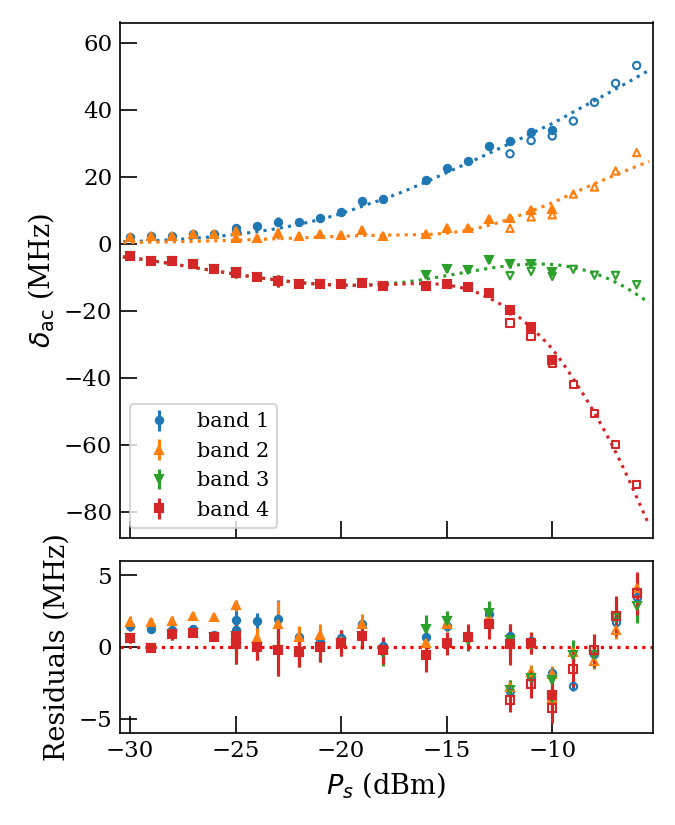

<ipython-input-73-903ea03de716>:93: RuntimeWarning: divide by zero encountered in log10
  x_ac = 20*np.log10(varied[1]/scale)


116
tab:blue
115
tab:orange
117
tab:green
114
tab:red
zero_x : -6.624959262210293dBm
zero_x : -6.189454185826974dBm
zero_x : -5.869877975354557dBm
zero_x : -5.447872762908345dBm


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [73]:
# create plot of experiment data and fitted numerical data

inv_cal = interp1d(y_pk, x_set, kind="linear")
colors = ['tab:blue','tab:orange', 'tab:green', 'tab:red']

ax_fontsize = 13
tick_labelsize = 11
legend_fontsize = 11
markersize = 3.5
markers = "o^vsD*"
linestyles = [':',':', ':', ':']

fig,axar = plt.subplots(2,1,figsize=(4.5,5.5),gridspec_kw={'height_ratios': [3, 1]})#,sharex=True)
ax = axar[0]
for band in range(n_bands):
    lab = f"experiment" if band == 0 else ""
    lab = f"band {band+1}"
    #lab = f"experimental {band}"
    ax.errorbar(
        inv_cal(x_data)[:-vn],
        (dACs[band]-func(x_data,*fits))[:-vn],
        yerr = dACs_er[band][:-vn],
        fmt = markers[band], 
        label=lab,
        c=colors[band],
        ms=markersize
    )
#ax.errorbar(xdat,ydat+dAC_split[1:]/2,fmt=".")
#ax.errorbar(xdat,ydat-dAC_split[1:]/2,fmt=".")
xlin = np.linspace(min(xdat),max(xdat),1000)

#y = 0.6
#x_data_3_p = x_data_3+np.log10(1+y*10**-(x_data_3/20))
#for band in range(n_bands):
#    lab = "verification data" if band == 0 else ""
#    ax.errorbar(x_data_3_p,dACs3[band]-func(x_data_3_p,*fits)+10*0-22, yerr = dACs3_er[band], fmt="o", label=lab)

if dataset == 60:
    x_data_2 = x_ver
    dACs_2 = dACs_ver
    dACs_2_er = dACs_ver_er
elif dataset == 80:
    x_data_2 = x_data_60
    dACs_2 = dACs_60
    dACs_2_er = dACs_60_er
ms=8
plot_vers = True
if plot_vers:
    y = 0.0
    lab=""
    #x_data_2_p = x_data_2+np.log10(1+y*10**-(x_data_2/20))
    for band in range(n_bands):
        # lab = "verification data" if band == 0 else ""
        #ax.errorbar(
        #    inv_cal(x_data_2),
        #    dACs_2[band]-func(x_data_2,*fits),
        #    yerr = dACs_2_er[band], 
        #    fmt=markers[band],
        #    label=lab,
        #    fillstyle="none",
        #    c=colors[band],
        #    ms=markersize
        #)
        ax.scatter(
            inv_cal(x_data_2),
            dACs_2[band]-func(x_data_2,*fits),
            marker=markers[band], 
            label=lab, 
            facecolors="none",
            edgecolors=colors[band],
            s=markersize**2)
        

    
thrs = 0.10


basis_t = [i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]

#Reorder experiment bands
tmp = basis_t[1]
basis_t[1] = basis_t[2]
basis_t[2] = tmp
basis_t = basis_t[1:] + basis_t[:1]

interesting_inds = []
for t_ind in basis_t:
    for k, ps in enumerate(eigenstates[:, t_ind, :]):
        if max(np.absolute(ps)**2) > thrs:
            interesting_inds.append(k)

interesting_inds = list(set(interesting_inds))
x_ac = 20*np.log10(varied[1]/scale)
interp_inds = np.argwhere((x_ac > min(y_pk))*(x_ac < max(y_pk))).T[0]
x_acp = x_ac[interp_inds]
energiesp = energies[:,interp_inds]
for i,k in enumerate(basis_t):
#for i,k in enumerate(interesting_inds[::-1]): 
    lab = f"fit" if i==0 else ""
    lab = ""
    #lab = f"fit {i}"
    print(k)
    print(colors[i])
    ax.plot(inv_cal(x_acp), 1e-6*(energiesp[k]-energies[k,0])/tau-func(x_acp,*fits), ls=linestyles[i], label=lab, c=colors[i])
#ax.plot(xlin,func2(xlin,*fits), label="Fit to CoM")
#ax.axvline(inv_cal(20*np.log10(25.5/scale)),ls=":",label="Expected Polarizability minumum")
zero_xs = [78.6,82.6,85.6,89.6]
for i,zerox in enumerate(zero_xs):
    # ax.axvline(inv_cal(20*np.log10(zerox/scale)),ls="--",c=colors[i],linewidth=1)#,label="Polarizability minumum")
    print(f"zero_x : {inv_cal(20*np.log10(zerox/scale))}dBm")

#ax.axvline()

ax.set_xlim(-30.5,-5.25)
ax.set_ylim(-88,66)

ax.legend(loc=3)
#ax.set_xlabel("Calibrated Dressing Power (dBm)")
#ax.set_xlabel("Dressing Power (dBm)")
ax.set_ylabel("$\delta_{\\rm ac}$ (MHz)")
ellip = fields["ellipticity"]
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#ax.set_title(f"AC stark shift fit - CoG\n$\omega_{{d}}=2\pi \cdot 4780MHz$\n$\epsilon={ellip:.5f}; V_{{ref}} = {scale:.2f}V/m$")

for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize(ax_fontsize)

ax = axar[1]
for band in range(n_bands):
    y_interp = np.interp(x_data,x_ac, 1e-6*(energies[basis_t[band]]-energies[basis_t[band],0])/tau)
    '''
    if band == 1:
        band = 2
    elif band == 2:
        band = 1
    '''
    res = dACs[band] - y_interp
    ax.errorbar(inv_cal(x_data)[:-vn],res[:-vn],yerr=dACs_er[band][:-vn],fmt=markers[band],label=f"band {band}", c=colors[band],ms=markersize)
    if plot_vers:
        y_interp = np.interp(x_data_2,x_ac,1e-6*(energies[basis_t[band]]-energies[basis_t[band],0])/tau)
        lab = "verification data" if band == 0 else ""
        # ax.scatter(inv_cal(x_data_2),dACs_2[band]-y_interp, marker=markers[band], label=lab, facecolors="none",edgecolors=colors[band],s=markersize**2)
        ax.errorbar(inv_cal(x_data_2),dACs_2[band]-y_interp, yerr=dACs_2_er[band],fmt=markers[band], ms=markersize, label=lab, c=colors[band], fillstyle="none")
ax.set_ylim(-6,6)
ax.set_xlim(-30.5,-5.5)
#ax.legend(loc=3)
ax.axhline(0,ls=":",c="r")

#ax.set_xlabel("Calibrated Dressing Power (dBm)")

ax.set_xlabel("$P_s$ (dBm)")
ax.set_ylabel("Residuals (MHz)")
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

axar[0].get_shared_x_axes().join(axar[0], axar[1])
axar[0].set_xticklabels([])
axar[1].set_xlim(axar[0].get_xlim())
#axar[0].set_xlim
#ax.set_title(f"AC stark shift fit residuals\n$\omega_{{d}}=2\pi \cdot 4780MHz$\n$\epsilon={ellip:.5f}; V_{{ref}} = {scale:.2f}V_{{cal}}/m$")

for ax in axar:
    ax.tick_params(labelsize=tick_labelsize)
    for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
        txt.set_fontsize(ax_fontsize)
    ax.minorticks_off()

fig.tight_layout()
fig.show()
fig.savefig(os.path.join(plots_dir,"Calibrated AC stark map.png"))
fig.savefig(os.path.join(plots_dir,"Calibrated AC stark map.eps"))
zfigs_dir = r"Z:\Public\Hybrid\Publications\Dressing in Cryostat\figures_TODO"
fig.savefig(os.path.join(zfigs_dir,"Calibrated AC stark map.png"))

<IPython.core.display.Javascript object>


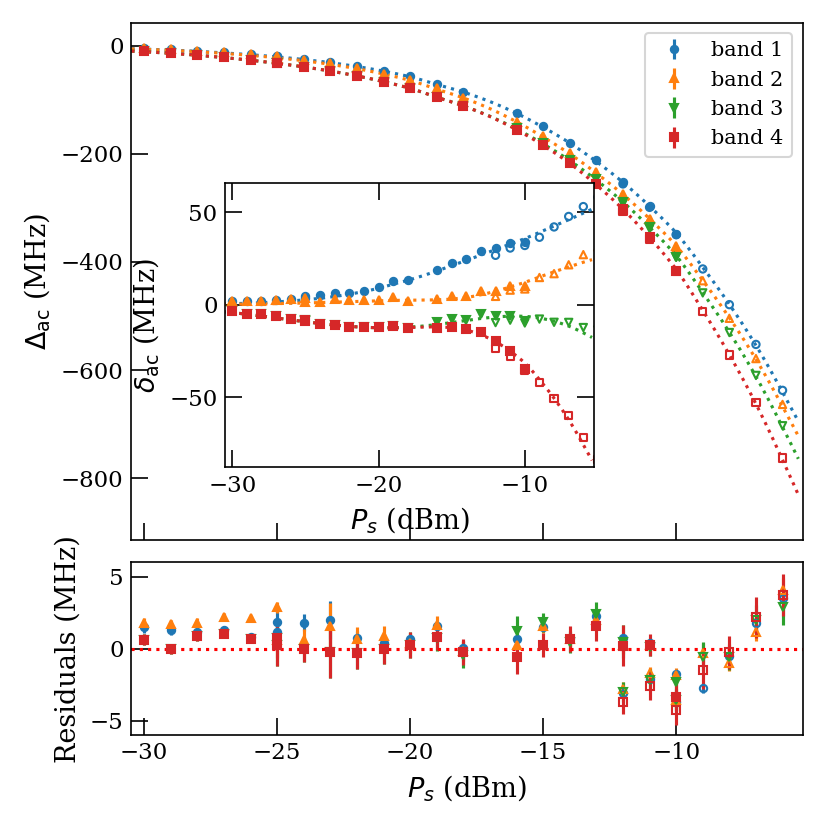

116
tab:blue
115
tab:orange
117
tab:green
114
tab:red
zero_x : -6.624959262210293dBm
zero_x : -6.189454185826974dBm
zero_x : -5.869877975354557dBm
zero_x : -5.447872762908345dBm


<ipython-input-100-734509177a16>:93: RuntimeWarning: divide by zero encountered in log10
  x_ac = 20*np.log10(varied[1]/scale)


In [100]:
# create plot of experiment data and fitted numerical data

inv_cal = interp1d(y_pk, x_set, kind="linear")
colors = ['tab:blue','tab:orange', 'tab:green', 'tab:red']

ax_fontsize = 13
tick_labelsize = 11
legend_fontsize = 11
markersize = 3.5
markers = "o^vsD*"
linestyles = [':',':', ':', ':']

fig,axar = plt.subplots(2,1,figsize=(5.5,5.5),gridspec_kw={'height_ratios': [3, 1]})#,sharex=True)
ax = axar[0]
for band in range(n_bands):
    lab = f"experiment" if band == 0 else ""
    lab = f"band {band+1}"
    #lab = f"experimental {band}"
    ax.errorbar(
        inv_cal(x_data)[:-vn],
        dACs[band][:-vn], #-func(x_data,*fits))[:-vn],
        yerr = dACs_er[band][:-vn],
        fmt = markers[band], 
        label=lab,
        c=colors[band],
        ms=markersize
    )
#ax.errorbar(xdat,ydat+dAC_split[1:]/2,fmt=".")
#ax.errorbar(xdat,ydat-dAC_split[1:]/2,fmt=".")
xlin = np.linspace(min(xdat),max(xdat),1000)

#y = 0.6
#x_data_3_p = x_data_3+np.log10(1+y*10**-(x_data_3/20))
#for band in range(n_bands):
#    lab = "verification data" if band == 0 else ""
#    ax.errorbar(x_data_3_p,dACs3[band]-func(x_data_3_p,*fits)+10*0-22, yerr = dACs3_er[band], fmt="o", label=lab)

if dataset == 60:
    x_data_2 = x_ver
    dACs_2 = dACs_ver
    dACs_2_er = dACs_ver_er
elif dataset == 80:
    x_data_2 = x_data_60
    dACs_2 = dACs_60
    dACs_2_er = dACs_60_er
ms=8
plot_vers = True
if plot_vers:
    y = 0.0
    lab=""
    #x_data_2_p = x_data_2+np.log10(1+y*10**-(x_data_2/20))
    for band in range(n_bands):
        # lab = "verification data" if band == 0 else ""
        #ax.errorbar(
        #    inv_cal(x_data_2),
        #    dACs_2[band]-func(x_data_2,*fits),
        #    yerr = dACs_2_er[band], 
        #    fmt=markers[band],
        #    label=lab,
        #    fillstyle="none",
        #    c=colors[band],
        #    ms=markersize
        #)
        ax.scatter(
            inv_cal(x_data_2),
            dACs_2[band],#-*func(x_data_2,*fits),
            marker=markers[band], 
            label=lab, 
            facecolors="none",
            edgecolors=colors[band],
            s=markersize**2)
        

    
thrs = 0.10


basis_t = [i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]

#Reorder experiment bands
tmp = basis_t[1]
basis_t[1] = basis_t[2]
basis_t[2] = tmp
basis_t = basis_t[1:] + basis_t[:1]

interesting_inds = []
for t_ind in basis_t:
    for k, ps in enumerate(eigenstates[:, t_ind, :]):
        if max(np.absolute(ps)**2) > thrs:
            interesting_inds.append(k)

interesting_inds = list(set(interesting_inds))
x_ac = 20*np.log10(varied[1]/scale)
interp_inds = np.argwhere((x_ac > min(y_pk))*(x_ac < max(y_pk))).T[0]
x_acp = x_ac[interp_inds]
energiesp = energies[:,interp_inds]
for i,k in enumerate(basis_t):
#for i,k in enumerate(interesting_inds[::-1]): 
    lab = f"fit" if i==0 else ""
    lab = ""
    #lab = f"fit {i}"
    print(k)
    print(colors[i])
    ax.plot(inv_cal(x_acp), 1e-6*(energiesp[k]-energies[k,0])/tau, ls=linestyles[i], label=lab, c=colors[i])
#ax.plot(xlin,func2(xlin,*fits), label="Fit to CoM")
#ax.axvline(inv_cal(20*np.log10(25.5/scale)),ls=":",label="Expected Polarizability minumum")
zero_xs = [78.6,82.6,85.6,89.6]
for i,zerox in enumerate(zero_xs):
    # ax.axvline(inv_cal(20*np.log10(zerox/scale)),ls="--",c=colors[i],linewidth=1)#,label="Polarizability minumum")
    print(f"zero_x : {inv_cal(20*np.log10(zerox/scale))}dBm")

#ax.axvline()

ax.set_xlim(-30.5,-5.25)
#ax.set_ylim(-88,66)

ax.legend(loc=1)
#ax.set_xlabel("Calibrated Dressing Power (dBm)")
#ax.set_xlabel("Dressing Power (dBm)")
ax.set_ylabel("$\Delta_{\\rm ac}$ (MHz)")
ellip = fields["ellipticity"]
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
#ax.set_title(f"AC stark shift fit - CoG\n$\omega_{{d}}=2\pi \cdot 4780MHz$\n$\epsilon={ellip:.5f}; V_{{ref}} = {scale:.2f}V/m$")

for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize(ax_fontsize)

ax = axar[1]
for band in range(n_bands):
    y_interp = np.interp(x_data,x_ac, 1e-6*(energies[basis_t[band]]-energies[basis_t[band],0])/tau)
    '''
    if band == 1:
        band = 2
    elif band == 2:
        band = 1
    '''
    res = dACs[band] - y_interp
    ax.errorbar(inv_cal(x_data)[:-vn],res[:-vn],yerr=dACs_er[band][:-vn],fmt=markers[band],label=f"band {band}", c=colors[band],ms=markersize)
    if plot_vers:
        y_interp = np.interp(x_data_2,x_ac,1e-6*(energies[basis_t[band]]-energies[basis_t[band],0])/tau)
        lab = "verification data" if band == 0 else ""
        # ax.scatter(inv_cal(x_data_2),dACs_2[band]-y_interp, marker=markers[band], label=lab, facecolors="none",edgecolors=colors[band],s=markersize**2)
        ax.errorbar(inv_cal(x_data_2),dACs_2[band]-y_interp, yerr=dACs_2_er[band],fmt=markers[band], ms=markersize, label=lab, c=colors[band], fillstyle="none")
ax.set_ylim(-6,6)
ax.set_xlim(-30.5,-5.5)
#ax.legend(loc=3)
ax.axhline(0,ls=":",c="r")

#ax.set_xlabel("Calibrated Dressing Power (dBm)")

ax.set_xlabel("$P_s$ (dBm)")
ax.set_ylabel("Residuals (MHz)")
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

axar[0].get_shared_x_axes().join(axar[0], axar[1])
axar[0].set_xticklabels([])
axar[1].set_xlim(axar[0].get_xlim())
#axar[0].set_xlim
#ax.set_title(f"AC stark shift fit residuals\n$\omega_{{d}}=2\pi \cdot 4780MHz$\n$\epsilon={ellip:.5f}; V_{{ref}} = {scale:.2f}V_{{cal}}/m$")

for ax in axar:
    ax.tick_params(labelsize=tick_labelsize)
    for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
        txt.set_fontsize(ax_fontsize)
    ax.minorticks_off()

fig.tight_layout()
fig.show()
#fig.savefig(os.path.join(plots_dir,"Calibrated AC stark map.png"))
#fig.savefig(os.path.join(plots_dir,"Calibrated AC stark map.eps"))
zfigs_dir = r"Z:\Public\Hybrid\Publications\Dressing in Cryostat\figures_TODO"


In [101]:
ax = axar[0]
ax = ax.inset_axes((0.14,0.14,.55,.55))
for band in range(n_bands):
    lab = f"experiment" if band == 0 else ""
    lab = f"band {band+1}"
    #lab = f"experimental {band}"
    ax.errorbar(
        inv_cal(x_data)[:-vn],
        (dACs[band]-func(x_data,*fits))[:-vn],
        yerr = dACs_er[band][:-vn],
        fmt = markers[band], 
        label=lab,
        c=colors[band],
        ms=markersize
    )

if dataset == 60:
    x_data_2 = x_ver
    dACs_2 = dACs_ver
    dACs_2_er = dACs_ver_er
elif dataset == 80:
    x_data_2 = x_data_60
    dACs_2 = dACs_60
    dACs_2_er = dACs_60_er
ms=8
plot_vers = True
if plot_vers:
    y = 0.0
    lab=""
    for band in range(n_bands):

        ax.scatter(
            inv_cal(x_data_2),
            dACs_2[band]-func(x_data_2,*fits),
            marker=markers[band], 
            label=lab, 
            facecolors="none",
            edgecolors=colors[band],
            s=markersize**2)

for i,k in enumerate(basis_t):
#for i,k in enumerate(interesting_inds[::-1]): 
    lab = f"fit" if i==0 else ""
    lab = ""
    #lab = f"fit {i}"
    print(k)
    print(colors[i])
    ax.plot(inv_cal(x_acp), 1e-6*(energiesp[k]-energies[k,0])/tau-func(x_acp,*fits), ls=linestyles[i], label=lab, c=colors[i])

ax.set_xlim(-30.5,-5.25)
ax.set_ylim(-88,66)

ax.set_xlabel("$P_s$ (dBm)")
ax.set_ylabel("$\delta_{\\rm ac}$ (MHz)")

ax.tick_params(labelsize=tick_labelsize)
for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize(ax_fontsize)
ax.minorticks_off()

fig.tight_layout()
fig.savefig(os.path.join(zfigs_dir,"Calibrated AC stark map, inset.png"))

116
tab:blue
115
tab:orange
117
tab:green
114
tab:red


In [55]:
help(ax.inset_axes)

Help on method inset_axes in module matplotlib.axes._axes:

inset_axes(bounds, *, transform=None, zorder=5, **kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    Add a child inset axes to this existing axes.
    
    Warnings
    --------
    This method is experimental as of 3.0, and the API may change.
    
    Parameters
    ----------
    bounds : [x0, y0, width, height]
        Lower-left corner of inset axes, and its width and height.
    
    transform : `.Transform`
        Defaults to `ax.transAxes`, i.e. the units of *rect* are in
        axes-relative coordinates.
    
    zorder : number
        Defaults to 5 (same as `.Axes.legend`).  Adjust higher or lower
        to change whether it is above or below data plotted on the
        parent axes.
    
    **kwargs
        Other keyword arguments are passed on to the child `.Axes`.
    
    Returns
    -------
    ax
        The created `~.axes.Axes` instance.
    
    Examples
    --------
    This example ma

# Legacy
## ALL CODE BELOW THIS POINT IS NOT IN ACTIVE USE, KEPT AROUND FOR REMINDERS OF SYNTAX AND DEBUGGING

In [ ]:
thrs = 0.5
fig, ax = plt.subplots(1,1, figsize=(5,5))

basis_t = [i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
interesting_inds = []
for t_ind in basis_t:
    for k, ps in enumerate(eigenstates[:, t_ind, :]):
        if max(np.absolute(ps)**2) > thrs:
            interesting_inds.append(k)

interesting_inds = list(set(interesting_inds))
scale = 79.5/0.474
x_ac = 20*np.log10(varied[1]/scale)
for k in interesting_inds:
    ax.plot(x_ac, 1e-6*np.real(energies[k,:]-energies[k,0]*0)/tau,label = basis[k%len(basis)].ket())

scale = 79.5/0.474
x_ac = 20*np.log10(varied[1]/scale)
for band in range(n_bands):
    ax.errorbar(x_data, dACs[band], yerr = dACs_er[band], fmt = ".", label=f"band {band}")

ax.set_title(f"AC stark shifts\n$\omega_D = {fields['field_omega']*1e-6/tau:.0f} MHz$; $\epsilon = {fields['ellipticity']:.3f}$; $P_{{scale}}={scale:.0f}V/m$")
ax.set_ylabel("$\Delta_{AC}(MHz)$")
ax.set_xlabel("Dressing Power (dBm)")
#ax.set_ylim(-900,-80)
ax.set_xlim(-20,max(x_ac))
#ax.set_xscale("log")
#ax.set_yscale("symlog")
#ax.set_title(f"Bands wrt Ellipticity\n$\omega_D = {fields['field_omega']*1e-6/tau:.0f} MHz$\nEac = {fields['Eac']:.3f} V/m\n")
#ax.set_ylabel(f"Band Energy - $E_{{{t_level.ket()}}}$ (MHz)")
#ax.set_xlabel("Dressing Field Ellipticity")
ax.legend()
for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("14")
fig.tight_layout()
fig.show()
#fig.savefig(f"Theory-Experiment_handscale_ellipticity_{fields['ellipticity']:.3f}.png")#
#fig.savefig(f"Band Frequency ellipticity.png")

In [ ]:

fits = [alphas[42],cs[67]]
func = lambda x, alpha, c: alpha*(np.sqrt(c**2+10**(x/10)) - c)
xdat = x_data_dBm[1:]

fig,ax = plt.subplots(1,1)
for band in bands:
    measured_res = res_df[y_str.format(band)]
    errb = res_df[er_str.format(band)]
    dAC = (measured_res-bare_res)
    dAC_er = errb
    ax.errorbar(x_data_dBm[1:], dAC[1:], yerr = dAC_er[1:], fmt = ".", label=f"band {band}")
#ax.errorbar(xdat,ydat+dAC_split[1:]/2,fmt=".")
#ax.errorbar(xdat,ydat-dAC_split[1:]/2,fmt=".")
xlin = np.linspace(min(xdat),max(xdat),1000)
ax.plot(xlin,func2(xlin,*fits), label="Fit to CoM")
ax.legend()
ax.set_xlabel("Dressing Power (dBm)")
ax.set_ylabel("$\Delta_{AC}$ at 1190 (MHz)")
ax.set_title(f"AC stark shift CoM fit\n$\omega_{{d}}=2\pi \cdot 4780MHz$")

for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("14")
fig.tight_layout()
fig.show()

fig,ax = plt.subplots(1,1)
ax.errorbar(xdat,ydat-func2(xdat,*fits),yerr=yer,fmt=".")
ax.set_xlabel("Dressing Power (dBm)")
ax.set_ylabel("Mean AC stark shift - Fit value (MHz)")
ax.set_title(f"Fit Residuals\n$\omega_{{d}}=2\pi \cdot 4780MHz$")

for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("14")
fig.tight_layout()

fig.show()

print(fits)

In [ ]:
20*np.log10(55/scale)

In [ ]:
dACs.mean[1]

def abs_split(ar):
    return abs(max(ar)-min(ar))
dAC_CoM = (np.array([np.nanmean([row[y_str.format(band)] for band in bands]) for ind,row in res_df.iterrows()])-bare_res)
dAC_CoM_er = np.array([np.sum([row[er_str.format(band)]**2 for band in bands]) for ind,row in res_df.iterrows()])
dAC_split = np.array([abs_split([row[y_str.format(band)] for band in bands]) for ind,row in res_df.iterrows()])

In [ ]:
fig, ax = plt.subplots(1,1)
ax.errorbar(x_data_dBm[1:],dAC_CoM[1:],yerr=dAC_CoM_er[1:],fmt=".")
ax.plot(x_data_dBm[1:],dAC_CoM[1:]+dAC_split[1:]/2)
ax.plot(x_data_dBm[1:],dAC_CoM[1:]-dAC_split[1:]/2)
ax.set_title("COM and Splitting verify")
for band in bands:
    measured_res = res_df[y_str.format(band)]
    errb = res_df[er_str.format(band)]
    dAC = (measured_res-bare_res)
    dAC_er = errb
    ax.errorbar(x_data_dBm[1:], dAC[1:], yerr = dAC_er[1:], fmt = ".")
fig.show()

In [ ]:
res_df = pd.read_csv("Measured_RF_Resonances_4780.csv")
#res_df = pd.read_csv("Measured_RF_Resonances_4780_2.csv")
res_df

In [ ]:
bands = range(1,6)
x_data_dBm = res_df["RF power (dBm)"]
x_data_Vs = np.sqrt(10**(x_data_dBm/10))
y_str = "mu {} (MHz)"
er_str = "sig {} (MHz)"
bare_res = res_df["mu 1 (MHz)"][0]
fig, ax = plt.subplots(1,1, figsize=(5,5))
for band in bands:
    measured_res = res_df[y_str.format(band)]
    errb = res_df[er_str.format(band)]
    dAC = 2*(measured_res-bare_res)
    dAC_er = 2*errb
    ax.errorbar(x_data_dBm[1:], dAC[1:], yerr = dAC_er[1:], fmt = ".")
ax.set_yscale("symlog")
ax.set_title("Measured AC stark shifts\n4780MHz Dressing field")
ax.set_xlabel("Drive Power (dBm)")
ax.set_ylabel("$-\Delta_{AC} (MHz)$")
fig.tight_layout()
fig.show()
# fig.savefig("Unscaled Wiki AC stark shifts.png")

In [ ]:
def abs_split(ar):
    return abs(max(ar)-min(ar))
dAC_CoM = (np.array([np.nanmean([row[y_str.format(band)] for band in bands]) for ind,row in res_df.iterrows()])-bare_res)
dAC_CoM_er = np.array([np.sum([row[er_str.format(band)]**2 for band in bands]) for ind,row in res_df.iterrows()])
dAC_split = np.array([abs_split([row[y_str.format(band)] for band in bands]) for ind,row in res_df.iterrows()])

In [ ]:
fig, ax = plt.subplots(1,1)
ax.errorbar(x_data_dBm[1:],dAC_CoM[1:],yerr=dAC_CoM_er[1:],fmt=".")
ax.plot(x_data_dBm[1:],dAC_CoM[1:]+dAC_split[1:]/2)
ax.plot(x_data_dBm[1:],dAC_CoM[1:]-dAC_split[1:]/2)
ax.set_title("COM and Splitting verify")
for band in bands:
    measured_res = res_df[y_str.format(band)]
    errb = res_df[er_str.format(band)]
    dAC = (measured_res-bare_res)
    dAC_er = errb
    ax.errorbar(x_data_dBm[1:], dAC[1:], yerr = dAC_er[1:], fmt = ".")
fig.show()

In [ ]:
xdat = x_data_Vs[1:]
ydat = dAC_CoM[1:]
yer = dAC_CoM_er[1:]

func = lambda x, alpha, c: alpha*(np.sqrt(c**2+x**2)-c)
guess= [-1.76e3/2,1.4e-1]

popt,pcov = curve_fit(func,xdat,ydat,sigma=yer,p0=guess)
perr = np.sqrt(np.diag(pcov))

fig,ax = plt.subplots(1,1)
ax.errorbar(xdat,ydat,yerr=yer,fmt=".")
ax.errorbar(xdat,ydat+dAC_split[1:]/2,fmt=".")
ax.errorbar(xdat,ydat-dAC_split[1:]/2,fmt=".")
xlin = np.linspace(min(xdat),max(xdat),1000)
ax.plot(xlin,func(xlin,*popt))
ax.plot(xlin,func(xlin,*guess))
fig.show()

fig,ax = plt.subplots(1,1)
ax.errorbar(xdat,ydat-func(xdat,*guess),yerr=yer,fmt=".")
fig.show()

In [ ]:
def res(xdat,ydat,func,fit):
    return np.mean(ydat-func(xdat,*fit))

def res_rms(xdat,ydat,func,fit):
    return np.mean(np.sqrt(((ydat-func(xdat,*fit))**2).sum()))

alphas = np.linspace(-1.825,-1.55,100)*1e3/2
cs = np.linspace(0.8,1.3,100)*1e-1
residuals = np.zeros((len(alphas),len(cs)),dtype=float)
residuals_rms = np.zeros((len(alphas),len(cs)),dtype=float)
for i, alpha in enumerate(alphas):
    for j, c in enumerate(cs):
        residuals[i,j] = abs(res(xdat,ydat,func,[alpha,c]))
        residuals_rms[i,j] = res_rms(xdat,ydat,func,[alpha,c])

In [ ]:
fig,ax = plt.subplots(1,1)
alphas_step = (max(alphas)-min(alphas))/len(alphas)
cs_step = (max(cs)-min(cs))/len(cs)
extent = [
    min(cs)-cs_step/2,
    max(cs)+cs_step/2,
    max(alphas)+alphas_step/2,
    min(alphas)-alphas_step/2,

]
im = ax.imshow(residuals, interpolation="none", aspect="auto", extent=extent)
fig.colorbar(im,ax=ax, use_gridspec=True, shrink=.7)
ax.set_xlabel("c")
ax.set_ylabel("$\\alpha'$")
ax.set_xticks(cs.astype(float),minor=2)
ax.set_yticks(alphas.astype(float),minor=2)
fig.show()

fig,ax = plt.subplots(1,1)
alphas_step = (max(alphas)-min(alphas))/len(alphas)
cs_step = (max(cs)-min(cs))/len(cs)
extent = [
    min(cs)-cs_step/2,
    max(cs)+cs_step/2,
    max(alphas)+alphas_step/2,
    min(alphas)-alphas_step/2,

]
im = ax.imshow(residuals_rms, interpolation="none", aspect="auto", extent=extent, vmin=np.min(residuals_rms), vmax=np.min(residuals_rms)+10)
cbar = fig.colorbar(im,ax=ax, use_gridspec=True, shrink=.7, label="RMS of residuals")
cbar.set_label("RMS of fit residuals",size=12)
ax.set_xlabel("c")
ax.set_ylabel("$\\alpha'$")
ax.set_xticks(cs.astype(float),minor=2)
ax.set_yticks(alphas.astype(float),minor=2)
ax.set_title("Fit parameter raster scan")
for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("12")

fig.tight_layout()
fig.show()

In [ ]:
np.argwhere(residuals_rms==np.min(residuals_rms))[0]

In [ ]:
fits = [alphas[42],cs[67]]
func2 = lambda x, alpha, c: alpha*(np.sqrt(c**2+10**(x/10)) - c)
xdat = x_data_dBm[1:]

fig,ax = plt.subplots(1,1)
for band in bands:
    measured_res = res_df[y_str.format(band)]
    errb = res_df[er_str.format(band)]
    dAC = (measured_res-bare_res)
    dAC_er = errb
    ax.errorbar(x_data_dBm[1:], dAC[1:], yerr = dAC_er[1:], fmt = ".", label=f"band {band}")
#ax.errorbar(xdat,ydat+dAC_split[1:]/2,fmt=".")
#ax.errorbar(xdat,ydat-dAC_split[1:]/2,fmt=".")
xlin = np.linspace(min(xdat),max(xdat),1000)
ax.plot(xlin,func2(xlin,*fits), label="Fit to CoM")
ax.legend()
ax.set_xlabel("Dressing Power (dBm)")
ax.set_ylabel("$\Delta_{AC}$ at 1190 (MHz)")
ax.set_title(f"AC stark shift CoM fit\n$\omega_{{d}}=2\pi \cdot 4780MHz$")

for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("14")
fig.tight_layout()
fig.show()

fig,ax = plt.subplots(1,1)
ax.errorbar(xdat,ydat-func2(xdat,*fits),yerr=yer,fmt=".")
ax.set_xlabel("Dressing Power (dBm)")
ax.set_ylabel("Mean AC stark shift - Fit value (MHz)")
ax.set_title(f"Fit Residuals\n$\omega_{{d}}=2\pi \cdot 4780MHz$")

for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("14")
fig.tight_layout()

fig.show()

print(fits)

In [ ]:
fig,ax = plt.subplots(1,1)
for band in bands:
    measured_res = res_df[y_str.format(band)]
    errb = res_df[er_str.format(band)]
    dAC = (measured_res-bare_res)
    dAC_er = errb
    
    ax.errorbar(x_data_dBm[1:], 2*(dAC[1:]-(func2(x_data_dBm[1:],*fits))), yerr = dAC_er[1:], fmt = ".", label=f"band {band}")
#ax.errorbar(xdat,ydat+dAC_split[1:]/2,fmt=".")
#ax.errorbar(xdat,ydat-dAC_split[1:]/2,fmt=".")
xlin = np.linspace(min(xdat),max(xdat),1000)

x_ac = 20*np.log10(varied[1]/scale)
for k in basis_t:
    ax.plot(x_ac, 1e-6*energies[k]/tau-2*func2(x_ac,*fits))
#ax.plot(xlin,func2(xlin,*fits), label="Fit to CoM")
ax.legend()
ax.set_xlim(-20,max(x_ac))
ax.set_xlabel("Dressing Power (dBm)")
ax.set_ylabel("$\Delta_{AC}$ at 1190 (MHz)")
ax.set_title(f"AC stark shift CoM fit\n$\omega_{{d}}=2\pi \cdot 4780MHz$")

for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("14")
fig.tight_layout()
fig.show()

In [ ]:
xdat = x_data_Vs[1:]
ydat = dAC_split[1:]
yer = dAC_CoM_er[1:]

func = lambda x, alpha, c: alpha*(np.sqrt(c**2+x**2)-c)
guess= [4.76e2, 2e-1]

popt,pcov = curve_fit(func,xdat,ydat,sigma=yer,p0=guess)
perr = np.sqrt(np.diag(pcov))

fig,ax = plt.subplots(1,1)
ax.errorbar(xdat,ydat,yerr=yer,fmt=".")
#ax.errorbar(xdat,ydat+dAC_split[1:]/2,fmt=".")
#ax.errorbar(xdat,ydat-dAC_split[1:]/2,fmt=".")
xlin = np.linspace(min(xdat),max(xdat),1000)
#ax.plot(xlin,func(xlin,*popt))
ax.plot(xlin,func(xlin,*guess))
fig.show()

fig,ax = plt.subplots(1,1)
ax.errorbar(xdat,ydat-func(xdat,*guess),yerr=yer,fmt=".")
fig.show()

In [ ]:
def res(xdat,ydat,func,fit):
    return np.mean(ydat-func(xdat,*fit))

def res_rms(xdat,ydat,func,fit):
    return np.mean(np.sqrt(((ydat-func(xdat,*fit))**2).sum()))

alphas = np.linspace(2.2,3.1,100)*1e2/2
cs = np.linspace(0.05,0.12,100)
residuals = np.zeros((len(alphas),len(cs)),dtype=float)
residuals_rms = np.zeros((len(alphas),len(cs)),dtype=float)
for i, alpha in enumerate(alphas):
    for j, c in enumerate(cs):
        residuals[i,j] = abs(res(xdat,ydat,func,[alpha,c]))
        residuals_rms[i,j] = res_rms(xdat,ydat,func,[alpha,c])

In [ ]:
fig,ax = plt.subplots(1,1)
alphas_step = (max(alphas)-min(alphas))/len(alphas)
cs_step = (max(cs)-min(cs))/len(cs)
extent = [
    min(cs)-cs_step/2,
    max(cs)+cs_step/2,
    max(alphas)+alphas_step/2,
    min(alphas)-alphas_step/2,

]
im = ax.imshow(residuals, interpolation="none", aspect="auto", extent=extent)
fig.colorbar(im,ax=ax, use_gridspec=True, shrink=.7)
ax.set_xlabel("c")
ax.set_ylabel("$\\alpha'$")
ax.set_xticks(cs.astype(float),minor=2)
ax.set_yticks(alphas.astype(float),minor=2)
fig.show()

fig,ax = plt.subplots(1,1)
alphas_step = (max(alphas)-min(alphas))/len(alphas)
cs_step = (max(cs)-min(cs))/len(cs)
extent = [
    min(cs)-cs_step/2,
    max(cs)+cs_step/2,
    max(alphas)+alphas_step/2,
    min(alphas)-alphas_step/2,

]
im = ax.imshow(residuals_rms, interpolation="none", aspect="auto", extent=extent, vmin=np.min(residuals_rms), vmax=np.min(residuals_rms)+10)
fig.colorbar(im,ax=ax, use_gridspec=True, shrink=.7)
ax.set_xlabel("c")
ax.set_ylabel("$\\alpha'$")
ax.set_xticks(cs.astype(float),minor=2)
ax.set_yticks(alphas.astype(float),minor=2)
fig.tight_layout()
fig.show()

In [ ]:
np.argwhere(residuals_rms==np.min(residuals_rms))[0]

In [ ]:
fits = [alphas[49],cs[46]]

fig,ax = plt.subplots(1,1)
ax.errorbar(xdat,ydat,yerr=yer,fmt=".")
#ax.errorbar(xdat,ydat+dAC_split[1:]/2,fmt=".")
#ax.errorbar(xdat,ydat-dAC_split[1:]/2,fmt=".")
xlin = np.linspace(min(xdat),max(xdat),1000)
ax.plot(xlin,func(xlin,*fits))
fig.show()

fig,ax = plt.subplots(1,1)
ax.errorbar(xdat,ydat-func(xdat,*fits),yerr=yer,fmt=".")
fig.show()

In [ ]:
print(fits)

In [ ]:
func2 = lambda x, alpha, c: alpha*(np.sqrt(c**2+10**(x/10)) - c)

fits = [-854.17,0.1138]
xdat = x_data_dBm[1:]
ydat = dAC_CoM[1:]
yer = dAC_CoM_er[1:]

fig,ax = plt.subplots(1,1)
ax.errorbar(xdat,ydat,yerr=yer,fmt=".")
#ax.errorbar(xdat,ydat+dAC_split[1:]/2,fmt=".")
#ax.errorbar(xdat,ydat-dAC_split[1:]/2,fmt=".")
xlin = np.linspace(min(xdat),max(xdat),1000)
ax.plot(xlin,func2(xlin,*fits))
fig.show()

fig,ax = plt.subplots(1,1)
ax.errorbar(xdat,ydat-func2(xdat,*fits),yerr=yer,fmt=".")
fig.show()

In [ ]:
func2(-30,*fits)+40.5

In [ ]:
bands = range(1,6)
x_data_dBm = res_df["RF power (dBm)"]
x_data_Vs = np.sqrt(10**(x_data_dBm/10))
y_str = "mu {} (MHz)"
er_str = "sig {} (MHz)"
bare_res = res_df["mu 1 (MHz)"][0]
fig, ax = plt.subplots(1,1, figsize=(8,8))
for band in bands:
    measured_res = res_df[y_str.format(band)]
    errb = res_df[er_str.format(band)]
    dAC = 2*(measured_res-bare_res)
    dAC_er = 2*errb
    ax.errorbar(x_data_Vs, dAC, yerr = dAC_er, fmt = ".")
ax.set_title("AC stark shifts on $|52P_{3/2}$ induced by 4780MHz Dressing field")
ax.set_xlabel("Dressing Field Strength (arb)")
ax.set_ylabel("AC stark shift on $|52P_{3/2}>$ band (MHz)")
fig.tight_layout()
fig.show()
fig.savefig("Unscaled Wiki AC stark shifts.png")

In [ ]:
energies[basis_t].mean(0)

In [ ]:
levels, basis, basis_n = None, None, None

In [ ]:
fields = {
    "Eac": np.append(np.linspace(0,22,200), np.linspace(22+22/200,100,200)),
#    "Eac": 80,
#    "ellipticity": np.linspace(0,np.sqrt(0.04),200)**2,
    "ellipticity": 0.023,
    "field_omega": tau*4780e6,
    "Edc": 0.0,
    "theta": 0
}

for key, value in fields.items():
    try:
        tmp = value[1]
    except TypeError:
        continue
    else:
        varied = (key, value)

t_level = RydStateFS(52,1,3/2)
max_det = tau*30e9
dl = 1
n_max = 3

comp = {"n_max": n_max, "dl": dl, "max_det": max_det}

if levels is None:
    levels, basis = build_basis(t_level, max_det, single_side=False, dl=dl)
    basis_n = build_n_basis(basis, n_max)

In [ ]:
H0 = build_H0(basis, t_level, offset_zeeman=1e6)
energies, eigenstates = floquet_loop(basis, H0, n_max=n_max, varied=varied, **fields)

In [ ]:
thrs = 0.5
fig, ax = plt.subplots(1,1, figsize=(5,5))

basis_t = [i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
interesting_inds = []
for t_ind in basis_t:
    for k, ps in enumerate(eigenstates[:, t_ind, :]):
        if max(np.absolute(ps)**2) > thrs:
            interesting_inds.append(k)

interesting_inds = list(set(interesting_inds))
scale = 79.5/0.474
for k in interesting_inds:
    ax.plot(x_ac, 1e-6*np.real(energies[k,:]-energies[k,0]*0)/tau,label = basis[k%len(basis)].ket())

scale = 79.5/0.474
for band in range(n_bands):
    ax.errorbar(x_data, dACs, yerr = dACs_er, fmt = ".", label=f"band {band}")

ax.set_title(f"AC stark shifts\n$\omega_D = {fields['field_omega']*1e-6/tau:.0f} MHz$; $\epsilon = {fields['ellipticity']:.3f}$; $P_{{scale}}={scale:.0f}V/m$")
ax.set_ylabel("$\Delta_{AC}(MHz)$")
ax.set_xlabel("Dressing Power (dBm)")
#ax.set_ylim(-900,-80)
ax.set_xlim(-20,max(x_ac))
#ax.set_xscale("log")
#ax.set_yscale("symlog")
#ax.set_title(f"Bands wrt Ellipticity\n$\omega_D = {fields['field_omega']*1e-6/tau:.0f} MHz$\nEac = {fields['Eac']:.3f} V/m\n")
#ax.set_ylabel(f"Band Energy - $E_{{{t_level.ket()}}}$ (MHz)")
#ax.set_xlabel("Dressing Field Ellipticity")
ax.legend()
for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("14")
fig.tight_layout()
fig.show()
#fig.savefig(f"Theory-Experiment_handscale_ellipticity_{fields['ellipticity']:.3f}.png")#
#fig.savefig(f"Band Frequency ellipticity.png")

In [ ]:
fig,ax = plt.subplots(1,1)
for band in bands:
    measured_res = res_df[y_str.format(band)]
    errb = res_df[er_str.format(band)]
    dAC = (measured_res-bare_res)
    dAC_er = errb
    if band == 1:
        ax.errorbar(x_data_dBm[1:], 2*(dAC[1:]-(func2(x_data_dBm[1:],*fits))), yerr = dAC_er[1:], fmt = ".", label=f"measured resonances")
    else:
        ax.errorbar(x_data_dBm[1:], 2*(dAC[1:]-(func2(x_data_dBm[1:],*fits))), yerr = dAC_er[1:], fmt = ".")
#ax.errorbar(xdat,ydat+dAC_split[1:]/2,fmt=".")
#ax.errorbar(xdat,ydat-dAC_split[1:]/2,fmt=".")
xlin = np.linspace(min(xdat),max(xdat),1000)

scale = 79.5/0.473
x_ac = 20*np.log10(varied[1]/scale)
for k in basis_t:
    if k == min(basis_t):
        ax.plot(x_ac, 1e-6*energies[k]/tau-2*func2(x_ac,*fits), label = "computed resonances")
    else:
        ax.plot(x_ac, 1e-6*energies[k]/tau-2*func2(x_ac,*fits))
#ax.plot(xlin,func2(xlin,*fits), label="Fit to CoM")
ax.legend()
ax.set_xlim(-20,max(x_ac))
ax.set_xlabel("Dressing Power (dBm)")
ax.set_ylabel("$\Delta_{AC,i}$ - Mean (MHz)")
field_omega=fields["field_omega"]
ellipticity = fields["ellipticity"]
ax.set_title(f"AC stark shift CoM fit\n$\omega_{{d}}=2\pi \cdot {field_omega*1e-6/tau:.0f}MHz$; $\epsilon = {ellipticity}$; $P_{{scale}} = {scale:.0f}V/m$")

for txt in [ax.xaxis.label, ax.yaxis.label, ax.title]:
    txt.set_fontsize("14")
fig.tight_layout()
fig.show()

In [ ]:
k
len()

In [ ]:
eps = np.arange(0,0.045,0.005)
for ellip in eps:
    ellip = float(ellip)
    fields = {
        "Eac": np.append(np.linspace(0,22,200), np.linspace(22+22/200,100,200)),
        "ellipticity": ellip,
        "field_omega": tau*4780e6,
        "Edc": 0.0,
        "theta": 0
    }

    for key, value in fields.items():
        try:
            tmp = value[1]
        except TypeError:
            continue
        else:
            varied = (key, value)

    H0 = build_H0(basis, t_level, offset_zeeman=1e6)
    energies, eigenstates = floquet_loop(basis, H0, n_max=n_max, varied=varied, **fields)

    thrs = 0.5
    fig, ax = plt.subplots(1,1, figsize=(8,8))

    basis_t = [i+len(basis)*n_max for i, state in enumerate(basis) if [state.n, state.l, state.j] == [t_level.n, t_level.l, t_level.j]]
    interesting_inds = []
    for t_ind in basis_t:
        for k, ps in enumerate(eigenstates[:, t_ind, :]):
            if max(np.absolute(ps)**2) > thrs:
                interesting_inds.append(k)

    interesting_inds = list(set(interesting_inds))
    for k in interesting_inds:
        ax.plot(varied[1], 1e-6*np.real(energies[k,:]-energies[k,0])/tau, label = basis_n[k].ket())

    scale = 79/0.474
    for band in bands:
        measured_res = res_df[y_str.format(band)]
        errb = res_df[er_str.format(band)]
        dAC = 2*(measured_res-bare_res)
        dAC_er = 2*errb
        x_data_scaled = x_data_Vs*scale
        ax.errorbar(x_data_scaled, dAC, yerr = dAC_er, fmt = ".", label=f"band {band}")

    ax.set_title(f"AC stark shifts\n$\omega_D = {fields['field_omega']*1e-6/tau:.0f} MHz$\n$\epsilon = {fields['ellipticity']:.3f}$")
    ax.set_ylabel("AC stark shift (MHz)")
    ax.set_xlabel("AC field strength (V/m)")
    ax.legend()
    fig.tight_layout()
    fig.show()
    fig.savefig(f"Theory-Experiment_handscale_ellipticity_{fields['ellipticity']:.3f}.png")

In [ ]:
key

In [ ]:
type(value)

In [ ]:
basis_t

In [ ]:
basis[basis_t[3]].ket()